In [1]:
import random
from copy import deepcopy
from math import log10

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from matplotlib.axes import Axes
from IPython.display import display
import requests
import os 
from dotenv import load_dotenv

In [2]:
# Load environment variables 
load_dotenv('simulation.env')

# Access environment variables 
subgraph_url = os.environ['SUBGRAPH_URL']
api_host = os.environ['API_HOST']
api_key = os.environ['API_KEY']

if 'SUBGRAPH_URL' in os.environ and 'API_HOST' in os.environ and 'API_KEY' in os.environ:
    print(True)
else:
    print(False)

True


### Get safe balances from subgraph and channel balances from the topology api endpoint 

In [3]:
def get_subgraph_data():
    """
    This function retrieves safe_address-node_address-balance links from the
    specified subgraph using pagination.
    """

    query = """
            query SafeNodeBalance($first: Int, $skip: Int) {
                safes(first: $first, skip: $skip) {
                    registeredNodesInNetworkRegistry {
                    node {
                        id
                    }
                    safe {
                        id
                        balance {
                        wxHoprBalance
                        }
                    }
                    }
                }
            }
        """

    data = {
        "query": query,
        "variables": {
            "first": 1000,
            "skip": 0,
        },
    }
    subgraph_dict = {}
    more_content_available = True
    pagination_skip_size = 1000

    while more_content_available:
        try:
            response = requests.post(subgraph_url, json=data)

            if response.status_code != 200:
                print(f"Received status code {response.status_code} when querying The Graph API")
                break

            json_data = response.json()

        except requests.exceptions.RequestException:
            print("An error occurred while sending the request to subgraph endpoint")
            return {}
        except ValueError:
            print("An error occurred while parsing the response as JSON from subgraph endpoint")
            return {}
        except Exception:
            print("An unexpected error occurred")
            return {}

        safes = json_data["data"]["safes"]
        for safe in safes:
            for node in safe["registeredNodesInNetworkRegistry"]:
                node_address = node["node"]["id"]
                wxHoprBalance = node["safe"]["balance"]["wxHoprBalance"]
                safe_address = node["safe"]["id"]
                subgraph_dict[node_address] = {
                    "safe_address": safe_address,
                    "wxHOPR_balance": wxHoprBalance,
                }

        # Increment skip for the next iteration
        data["variables"]["skip"] += pagination_skip_size
        more_content_available = len(safes) == pagination_skip_size

    return subgraph_dict

def get_unique_nodeAddress_peerId_aggbalance_links(api_host, api_key):
    """
    Returns a dict containing all unique source_peerId-source_address links.
    """
    channel_url = "http://{}:3001/api/v3/channels/?includingClosed=false&fullTopology=true".format(api_host)
    headers = {'X-Auth-Token': api_key}
    response = requests.request("GET", channel_url, headers=headers)

    if response.status_code != 200:
        print("Could not fetch channel information. Status code: {}".format(response.status_code))
        return {}
    
    response = response.json()

    if 'all' not in response:
            print("Response does not contain `all`")
            return {}

    peerid_address_aggbalance_links = {}
    for item in response["all"]:
        if "sourcePeerId" not in item or "sourceAddress" not in item:
            print("Response does not contain `source_peerid` or `source_address`")
            continue

        if "status" not in item:
            print("Response does not contain `status`")
            continue

        source_peer_id = item["sourcePeerId"]
        source_address = item["sourceAddress"]
        balance = int(item["balance"]) / 1e18

        if item["status"] != "Open":
            # Other Statuses: "Waiting for commitment", "Closed", "Pending to close"
            # Ensures that nodes must have at least 1 open channel in to receive ct
            continue

        if source_peer_id not in peerid_address_aggbalance_links:
            peerid_address_aggbalance_links[source_peer_id] = {
                "source_node_address": source_address,
                "channels_balance": balance,
            }

        else:
            peerid_address_aggbalance_links[source_peer_id][
                "channels_balance"
            ] += balance

    return peerid_address_aggbalance_links

In [4]:
topology_data = get_unique_nodeAddress_peerId_aggbalance_links(api_host, api_key)

print(len(topology_data))

print_size = 5 

for key, value in list(topology_data.items())[:print_size]:
    print(f"{key}: {value}")

5
12D3KooWCo1zh7adR9e1HSR4ub6Hw7ow4Pi41egNnjTzdFJeAd7C: {'source_node_address': '0x0d3832bf4e8dd5f0ccd996fa2a27e1f864fd91bc', 'channels_balance': 9.2}
12D3KooWLXGhAQKgxPZAm5orxUtBAr2JmSbHTuNNCx68Rkxq3TPy: {'source_node_address': '0x89764aea7c471e4e04c67ee20b0b4ee3662cc9e4', 'channels_balance': 4.400000000000001}
12D3KooWHMd7WmzM9dDZJDaXPrbnkmRMAr9JaES98ZJ8YfSbWZ93: {'source_node_address': '0xe5ad48d9005f9529da75ded5d931c72bb14b0b19', 'channels_balance': 9.2}
12D3KooWQUb83ioj9uPRkk3VQKhw1gKBPSY22zZAKaRY47KLWUqA: {'source_node_address': '0x2eb08c7d673c4b7e8c017471e8d4de996aa82e83', 'channels_balance': 4.400000000000001}
12D3KooWN9jv7P5eKuKsZ9bkwgPCngzdCLghLicC9DFrN2xdpisz: {'source_node_address': '0xd33888a2a4cd8d4ddc6c499967934cf8111b79fc', 'channels_balance': 1e-17}


In [5]:
subgraph_data = get_subgraph_data()
print(len(subgraph_data))

print_size = 10 

for key, value in list(subgraph_data.items())[:print_size]:
    print(f"{key}: {value}")


47
0x78d294676bbd9030c6ff83899d4d42723a5ff71f: {'safe_address': '0x006936ee6fd2f05ef0230a8f87267ae31a1c2895', 'wxHOPR_balance': '10'}
0x915ab25afe89849084c021377dba14181e6839f4: {'safe_address': '0x0d4ec909963d2866b544cd0f6a7099c48a2dce2f', 'wxHOPR_balance': '0'}
0xd33888a2a4cd8d4ddc6c499967934cf8111b79fc: {'safe_address': '0x10cd8026bb8957687b949e973a478990eefb3334', 'wxHOPR_balance': '19.99999999999999999'}
0x0ff99382b671eb888bf7fd9f5c2bc7e2b2260c07: {'safe_address': '0x18722c769b33fbe2197a1ad4d9ffc55826ca5455', 'wxHOPR_balance': '20'}
0x89764aea7c471e4e04c67ee20b0b4ee3662cc9e4: {'safe_address': '0x1b676be89d75a7ae07ff57c57567987bb10304c8', 'wxHOPR_balance': '15.6'}
0x0d3832bf4e8dd5f0ccd996fa2a27e1f864fd91bc: {'safe_address': '0x20b9c99a400bde3e65ac5650772a77be9c52b4d6', 'wxHOPR_balance': '10.8'}
0xeced17c48f6b9cfe446132152ec08788e4b4279d: {'safe_address': '0x215cf7b5b52c738d6a6060a02cae9120f408166c', 'wxHOPR_balance': '10'}
0x2a9897045772e47ea0be1f38746ccce139709f26: {'safe_address'

### Merge Subgraph and Topology Data 

In [6]:
def merge_topology_subgraph(topology_dict: dict, subgraph_dict: dict):
    """
    Merge metrics and subgraph data with the unique peer IDs, addresses,
    balance links.
    :param: topology_dict: A dict mapping peer IDs to node addresses.
    :param: subgraph_dict: A dict containing subgraph data with safe address as the key.
    :returns: A dict with peer ID as the key and the merged information.
    """
    merged_result = {}

    # Merge based on peer ID with the channel topology as the baseline
    for peer_id, data in topology_dict.items():
        seen_in_subgraph = False

        source_node_address = data["source_node_address"]
        if source_node_address in subgraph_dict:
            subgraph_data = subgraph_dict[source_node_address]
            data["safe_address"] = subgraph_data["safe_address"]
            data["safe_balance"] = float(subgraph_data["wxHOPR_balance"])
            data["total_balance"] = data["channels_balance"] + data["safe_balance"]

            seen_in_subgraph = True
            # print(f"Source node address for {peer_id} found in subgraph")

        if seen_in_subgraph:
            merged_result[peer_id] = data

    return merged_result

In [7]:
merged_data = merge_topology_subgraph(topology_data, subgraph_data)
print(len(merged_data))

print_size = 5 

for key, value in list(merged_data.items())[:print_size]:
    print(f"{key}: {value}")


5
12D3KooWCo1zh7adR9e1HSR4ub6Hw7ow4Pi41egNnjTzdFJeAd7C: {'source_node_address': '0x0d3832bf4e8dd5f0ccd996fa2a27e1f864fd91bc', 'channels_balance': 9.2, 'safe_address': '0x20b9c99a400bde3e65ac5650772a77be9c52b4d6', 'safe_balance': 10.8, 'total_balance': 20.0}
12D3KooWLXGhAQKgxPZAm5orxUtBAr2JmSbHTuNNCx68Rkxq3TPy: {'source_node_address': '0x89764aea7c471e4e04c67ee20b0b4ee3662cc9e4', 'channels_balance': 4.400000000000001, 'safe_address': '0x1b676be89d75a7ae07ff57c57567987bb10304c8', 'safe_balance': 15.6, 'total_balance': 20.0}
12D3KooWHMd7WmzM9dDZJDaXPrbnkmRMAr9JaES98ZJ8YfSbWZ93: {'source_node_address': '0xe5ad48d9005f9529da75ded5d931c72bb14b0b19', 'channels_balance': 9.2, 'safe_address': '0x386b33c8ceae460403d6585a1d8cc38f945cbc7a', 'safe_balance': 10.8, 'total_balance': 20.0}
12D3KooWQUb83ioj9uPRkk3VQKhw1gKBPSY22zZAKaRY47KLWUqA: {'source_node_address': '0x2eb08c7d673c4b7e8c017471e8d4de996aa82e83', 'channels_balance': 4.400000000000001, 'safe_address': '0x6f835ded9e11b859de87bacbbec9e2be13

### Exclude CT Nodes and apply Balance Split  

In [8]:
def exclude_elements(source_data: dict, blacklist: list):
    """
    Removes elements from a dictionary based on a blacklist.
    :param: source_data (dict): The dictionary to be updated.
    :param: blacklist (list): A list containing the keys to be removed.
    :returns: nothing.
    """

    for key in blacklist:
        if key not in source_data:
            continue
        del source_data[key]
        print(f"Excluded {key} from the dataset.")

    return source_data 

def allow_many_node_per_safe(input_dict: dict):
    """
    Split the stake managed by a safe address equaly between the nodes
    that the safe manages.
    :param: input_dict: dictionary containing peerID, nodeAddress, safeAdress
        and total balance.
    :returns: nothing.
    """
    safe_address_counts = {}

    # Calculate the number of safe_addresses related to a node address
    for value in input_dict.values():
        safe_address = value["safe_address"]

        if safe_address not in safe_address_counts:
            safe_address_counts[safe_address] = 0

        safe_address_counts[safe_address] += 1

    # Update the input_dict with the calculated splitted_stake
    for value in input_dict.values():
        safe_address = value["safe_address"]
        channels_balance = value["channels_balance"]
        safe_balance = value["safe_balance"]
        value["safe_address_count"] = safe_address_counts[safe_address]

        value["splitted_stake"] = (
            safe_balance / value["safe_address_count"]
        ) + channels_balance

    return input_dict

In [9]:
blacklist = ["12D3KooWH9rfYNKMkNncYJxS7BH41ThPZUYe3FNkbfmJAa4n5r3x", "12D3KooWL16nW1Z2dLvyZWzr9ZZwoLTeuSfaKSeX2BjucHwSoEwJ", 
            "12D3KooWNYi2kG5cdeEUBvjemZRUkPVmAeXsSGVrX9QHnEiMfh8w","12D3KooWGyY39vD8J2VGEDjTCD3eEyvV4YrnKM9NCQa6SYJKczrR"]

exluded_elements_merged_data = exclude_elements(merged_data, blacklist)

print(len(exluded_elements_merged_data))

Excluded 12D3KooWH9rfYNKMkNncYJxS7BH41ThPZUYe3FNkbfmJAa4n5r3x from the dataset.
Excluded 12D3KooWL16nW1Z2dLvyZWzr9ZZwoLTeuSfaKSeX2BjucHwSoEwJ from the dataset.
Excluded 12D3KooWNYi2kG5cdeEUBvjemZRUkPVmAeXsSGVrX9QHnEiMfh8w from the dataset.
Excluded 12D3KooWGyY39vD8J2VGEDjTCD3eEyvV4YrnKM9NCQa6SYJKczrR from the dataset.
185


In [10]:
output_data = allow_many_node_per_safe(exluded_elements_merged_data)

print(len(output_data))

print_size = 15 

# for key, value in list(output_data.items())[:print_size]:
#     print(f"{key}: {value}")

print(output_data)


185
{'12D3KooWAAZ3WnaWMuSQnQSFYnwx7g6W725DYmDY1QASZK1nni5B': {'source_node_address': '0xfa73af5609d354acd0f6e51f77c04d228c370813', 'channels_balance': 250.0, 'safe_address': '0x8832376a388cfcb58dab0cce249f65b86041e4bc', 'safe_balance': 9767.21884352485, 'total_balance': 10017.21884352485, 'safe_address_count': 1, 'splitted_stake': 10017.21884352485}, '12D3KooWKn3bLWMymSMznYt3YRrK8cwmYytEzwM1HoDgqkLcmeSu': {'source_node_address': '0x8de95cdc3291152381f24226422ed9c08beec146', 'channels_balance': 2089.0, 'safe_address': '0x4d219619fa660c02236c89e5de46843bdeb41233', 'safe_balance': 86880.0, 'total_balance': 88969.0, 'safe_address_count': 1, 'splitted_stake': 88969.0}, '12D3KooWNJyWUuu9M9RNU8zTMyqCA8K1GqJwv8tjHsc2oYsJJajD': {'source_node_address': '0x9925b9846e6e289e1c7f8a0554bf6900757491ec', 'channels_balance': 109.0, 'safe_address': '0x5ce3ca7ae22be88a960e0847845d9e13e8b5f23d', 'safe_balance': 74943.0, 'total_balance': 75052.0, 'safe_address_count': 1, 'splitted_stake': 75052.0}, '12D3Koo

In [11]:
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(output_data, orient='index')

# Reset the index
df.reset_index(inplace=True)

# Rename the columns
df.columns = ['peer_id', 'source_node_address', 'channels_balance', 'safe_address', 'safe_balance', 'total_balance', 'safe_address_count', 'splitted_stake']

# Print the DataFrame
print(df.columns)

Index(['peer_id', 'source_node_address', 'channels_balance', 'safe_address',
       'safe_balance', 'total_balance', 'safe_address_count',
       'splitted_stake'],
      dtype='object')


In [13]:
df[df["peer_id"] == "12D3KooWPcFnhWMxeyvpFZGXionD1i4Vos2K1Fp7XeJq37TX6z7H"]

peer_id  \
152  12D3KooWPcFnhWMxeyvpFZGXionD1i4Vos2K1Fp7XeJq37...   

                            source_node_address  channels_balance  \
152  0xb1f6cafacf42a5b02406ca7dc3d5245483367ea7              37.0   

                                   safe_address  safe_balance  total_balance  \
152  0xc76b4ce40dd622321a4e187d2576c30e8b5ab0cc        9963.0        10000.0   

     safe_address_count  splitted_stake  
152                   1         10000.0

In [12]:
df[df['splitted_stake'] < 10000]

peer_id  \
34   12D3KooWScC7bj5YdjDLDX3ibxQjkJLeHPRGk4fdNr7jWn...   
41   12D3KooWNwGMS67P2CbSLehU7U1DENzxQQEotMNhHNo6cY...   
44   12D3KooWN1cxdPKqzEMeJh7RvwfcZWBh1dcniPhpsmfDBf...   
45   12D3KooWRMYvNUevu4Pd9ZxCbngy3XgjmL4xy16QGAPDBD...   
109  12D3KooWBXNrryGSu8nfcrxDZia4QYNta3QJ12uL8PVwC3...   
114  12D3KooWKAeU4QvjPYsvomzbVDXX8cPj49feJNZruppVDs...   
118  12D3KooWFSxmWxKLVRBnUb8G76Scd9ZTLYtBZjLmgPz429...   
120  12D3KooWDenWzj6suJagt8vWFGohbz4x3vg67A4pKYXdg2...   
122  12D3KooWQvvN4mPGr2KMZ8VoPVFA4DoYH9o7MWUdodSdY7...   
126  12D3KooWRgxXHmsbixysDBFcE49Mpb2T5Gwn3kpm7ZXSzC...   
134  12D3KooWRHKbEb2CNyipZ5vNFNZFAP48K6CNkN8mLt7iSb...   
150  12D3KooWRbkemN63B4kirDtcEUH6pegkNHV5TxdJRX4LYM...   
155  12D3KooWCXHCRKu4iieq57NdRk4dtYU9GAPJSaj7qrmsDy...   
161  12D3KooWQeRaz9YWr4ehfTnkwUVy79xZoymr25guJqHjog...   
162  12D3KooWRvkXaiogDRCyWpdDaDiRm5ixTjDfd4f3RpS1be...   
163  12D3KooWRgG6vAmLLZXq6Ne1JrBaaVa6j9eGtUhAhXMwUs...   
177  12D3KooWPzsXXqNffVddnUiGFzzWmR95MgTHBNBUeMfFbY...   
178  12D3KooWDnnepKxQZ6EbYc5GajaY6QXjwGMAd9yzMUq6y9...   

                            source_node_address  channels_balance  \
34   0xfbfc5497e511ebed91fb467fcb032046a5ad5e49      2.500000e-01   
41   0x35addec9ce4f901daf667b2d26d64fb569da8b46      2.100000e-01   
44   0x11d7d64cf1cf0984bfaf52274696c511d5742594      1.000000e+00   
45   0x7978e8b1211aad990b78689459433ccd605a7471      1.000000e+00   
109  0xff7570ba5fc8bac26d4536565c48474e09f37b0d      3.200000e-01   
114  0x7c1878ed46f57124d65225555fe8cb793ec7450b      2.100000e+01   
118  0xb353ca7e8f73fbfdd777774c8c441235e168461d      2.000000e-17   
120  0xa318d2f6962e4d1f3fab56ca400e09cfcc152935      5.000000e+00   
122  0x5d5c6a0f59c8c695d98fd71f0bfa050891a5ac82      1.000000e-01   
126  0x2c25eda3cf58910ab639c89c304065869e641f9f      3.000000e-02   
134  0x1d41be38add28cf0899aa2227123b76b1bdb2565      3.000000e+00   
150  0xf7f1f61f8c39b3034e294887e76c6b1ccee2f9e1      1.000000e-01   
155  0x115a005aecd1a656671806e78a2e3f6b8856b346      6.500000e+00   
161  0xb8cd81bb7edd36c1240a2c51cadbbbf9b7e73edd      3.000000e+00   
162  0x7d852faebb35adaed925869e028d9325bdd555a4      1.000000e-01   
163  0xda45fc48fcd4ac99a3fae9c1eb09e25331dd7851      1.500000e-01   
177  0xba1ecd960def530f38e38d805c4f1770a7bbd402      2.000000e+00   
178  0xc6c8e3a887e7db7413e53050e9617002831042e3      2.000000e-17   

                                   safe_address  safe_balance  total_balance  \
34   0x08bb65f98e81b108758e03cf1e9ca763dad72abe          9.75           10.0   
41   0xd2b0cc920b2e003ddfc2200bb75c158a85680df7          9.79           10.0   
44   0x1f4f301f9e038704487bb5a2535cd531ac233035          7.00            8.0   
45   0xb919403a7e49d345ab105924915f4cfc4082a9d5          1.00            2.0   
109  0x679bc9610e4c68ee8dc3e5c5046d599ad0e72f27          9.68           10.0   
114  0x08cd580b1541d75ca841c68673476f9e655c15cd       9969.00         9990.0   
118  0xe86a65dc226bcee3b538a297022c72be422bd600         10.50           10.5   
120  0x40ade876991138a4a7a49cf9009158bbd8a8a66d          7.00           12.0   
122  0x4a458b143561d1078768a34479e341e4ddabd16c          0.90            1.0   
126  0x0f81490a99c99e744ec941662a742d9c1297f268          9.97           10.0   
134  0x41715c0acaf5271dbfb2aa91bc350bc737ae2c21          1.00            4.0   
150  0x22be10812cd4ffbaa9a075ea8256359b436885a6          9.90           10.0   
155  0x99e8d9164803a64783376d1f30ee74116ac017c8          3.50           10.0   
161  0x7c8b6c46bc4f405b343b8af753a3c3edb387f6b3          7.00           10.0   
162  0x4dcd3aa8655f766c69a0c30124b56a91b97da946          9.90           10.0   
163  0x392b4485cb859fe49fdb9699be67b845c84effd5          9.85           10.0   
177  0x502d31374f4d6e9b1d97c64cbb3e0a268d5cbbb9          1.00            3.0   
178  0x59c4b45f76fa1d628c89d87c23d51c9fe626a9ed         11.00           11.0   

     safe_address_count  splitted_stake  
34                    1            10.0  
41                    1    

### TODO 

In [11]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 10e3:
            transformed_stakes.append(1e-20)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold  + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apy(opt: dict, data: list, percentage: bool = False, average: bool = True, on_stake: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    if percentage:
        factor = 100
    else:
        factor = 1

    period_apy = [r / s for r, s in zip(rewards, data if on_stake else transformed_stakes)]
    yearly_apy = [apy * 12 / opt["period_in_months"] * factor for apy in period_apy]
    
    apy = sum(yearly_apy) / len(yearly_apy) if average else yearly_apy  
  
    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

def probabilistic_apy(datas: list[list], options: list[dict], steps:int = 100):
    result_template = {"apys": [], "average": 0}

    results = [deepcopy(result_template) for _ in range(len(options))]

    for idx, opt in enumerate(options):
        for _ in range(steps):
            stakes = []
            for data, count in zip(datas, opt["data_count"]):
                if not count:
                    continue
                if count == "all":
                    stakes.extend(data)
                else:
                    stakes.extend(random.sample(data, count))

            tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
            
            apy = compute_apy(opt, tf_stakes, percentage=False)

            results[idx]["apys"].append(apy)

        results[idx]["average"] = np.mean(results[idx]["apys"])
        results[idx]["std"] = np.std(results[idx]["apys"])

    return results

def generate_simulation_graph(datas:list[list], options: list[dict], steps: int = 200, title: str = None, cols:int=3):
    rows = int(len(options) / cols + 0.5)
    if rows * cols < len(options):
        rows += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()


    results = probabilistic_apy(datas, options, steps)

    for opt, result, ax in zip(options, results, axes):
        max_stakes = max([max(data) for data, count in zip(datas, opt["data_count"]) if count])
        stakes = np.linspace(0, max_stakes, 1000)
        factor, prefix = factor_and_prefix(stakes[-1])
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])

        data_points = []
        for data, count in zip(datas, opt["data_count"]):
            if not count:
                continue
            if count == "all":
                data_points.extend(data)
            else:
                data_points.extend(random.sample(data, count))
       
        tf_data_points = stake_transformation(data_points, **opt["model_arguments"])

        stakes_for_plt = [s/factor for s in stakes]
        tf_stakes_for_plt = [s/factor for s in tf_stakes]

        data_points_for_plt = [s/factor for s in data_points]
        tf_data_points_for_plt = [s/factor for s in tf_data_points]
        
        messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)


        ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
        ax.scatter(data_points_for_plt, tf_data_points_for_plt, s=12, alpha=0.8, c="#ff7f0e")

        ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
        ax.set_ylabel(f"Transformed stake (/{prefix}/HOPR)")
        ax.text(0.1,
                0.8,
                f"APY: {result['average']:.2%} (+- {result['std']:.2%})",
                transform=ax.transAxes, 
                horizontalalignment='left', 
                bbox=dict(facecolor='red', alpha=0.5),)
        ax.text(0.1,
                0.7,
                f"Messages/s: {messages_per_second:.2f}",
                transform=ax.transAxes, 
                horizontalalignment='left', 
                bbox=dict(facecolor='blue', alpha=0.5),)
        
        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())
        
        ax.legend()
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()
        
    if title:
        if len(options) == 1:
            plt.title(title, fontsize=10)
        else:
            fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_graph_simple(options: list[dict], steps: int, title: str = None):
    rows = 1
    cols = int(len(options) / rows + 0.5)
    if rows * cols < len(options):
        cols += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    for opt, ax in zip(options, axes):        
        stakes = np.linspace(0, 1e6, steps)
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
        
        ax.plot(stakes, tf_stakes)
        ax.set_xlabel(f"Stakes (HOPR)")
        ax.set_ylabel(f"Transformed Stakes (HOPR)")
    
        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())
        
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()
        
    if title:
        fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_table(datas:list[list], options: list[dict], imposed_counts: list, steps: int = 200):
    
    apy_array = []
    messages_array = []
    combined_array = []

    for opt in options:
        temp_apy_array = []
        temp_messages_array = []
        temp_combined_array = []

        for count in imposed_counts:
            opt["data_count"] = count

            result = probabilistic_apy(datas, [opt], steps)[0]
            
            messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)

            temp_apy_array.append(f"{result['average']:.2%}")
            temp_messages_array.append(f"{messages_per_second:.2f}")
            temp_combined_array.append(f"{result['average']:.2%} / {messages_per_second:.2f}m/s")

        apy_array.append(temp_apy_array)
        messages_array.append(temp_messages_array)
        combined_array.append(temp_combined_array)

    return apy_array, messages_array, combined_array

In [12]:
raw_all = pd.read_csv("all_01H7Z22K1VRTXCWJJJFV2A64VP.csv", low_memory=False)
raw_nft = pd.read_csv("nft_01H7Z2W99SMWJ01YN552WSRADV.csv", low_memory=False)

raw_data = pd.merge(raw_all, raw_nft, on="account", how="left")

condition = raw_data["token_id"].isnull()

staking_info_nft_holders = list(raw_data[~condition]["actual_stake_x"])
staking_info_non_nft_holders = list(raw_data[condition]["actual_stake_x"])
staking_info_all = list(raw_data["actual_stake_x"])

datas = [staking_info_nft_holders, staking_info_non_nft_holders, [500_000/0.05]]

# aim for 15% APY
prefered = {
    "data_count": ["all", 0, 0],
    "budget": 100_000, # fixed
    "period_in_months": 1, # fixed
    "model_arguments": {
        "slope": 1, # fixed
        "curvature":1.4,
        "threshold":75e3,
    },
    "ticket_options": { # fixed
        "price": 1, # fixed
        "winning_probability": 1, # fixed
    },
    "legend": "",
}


### Economic model

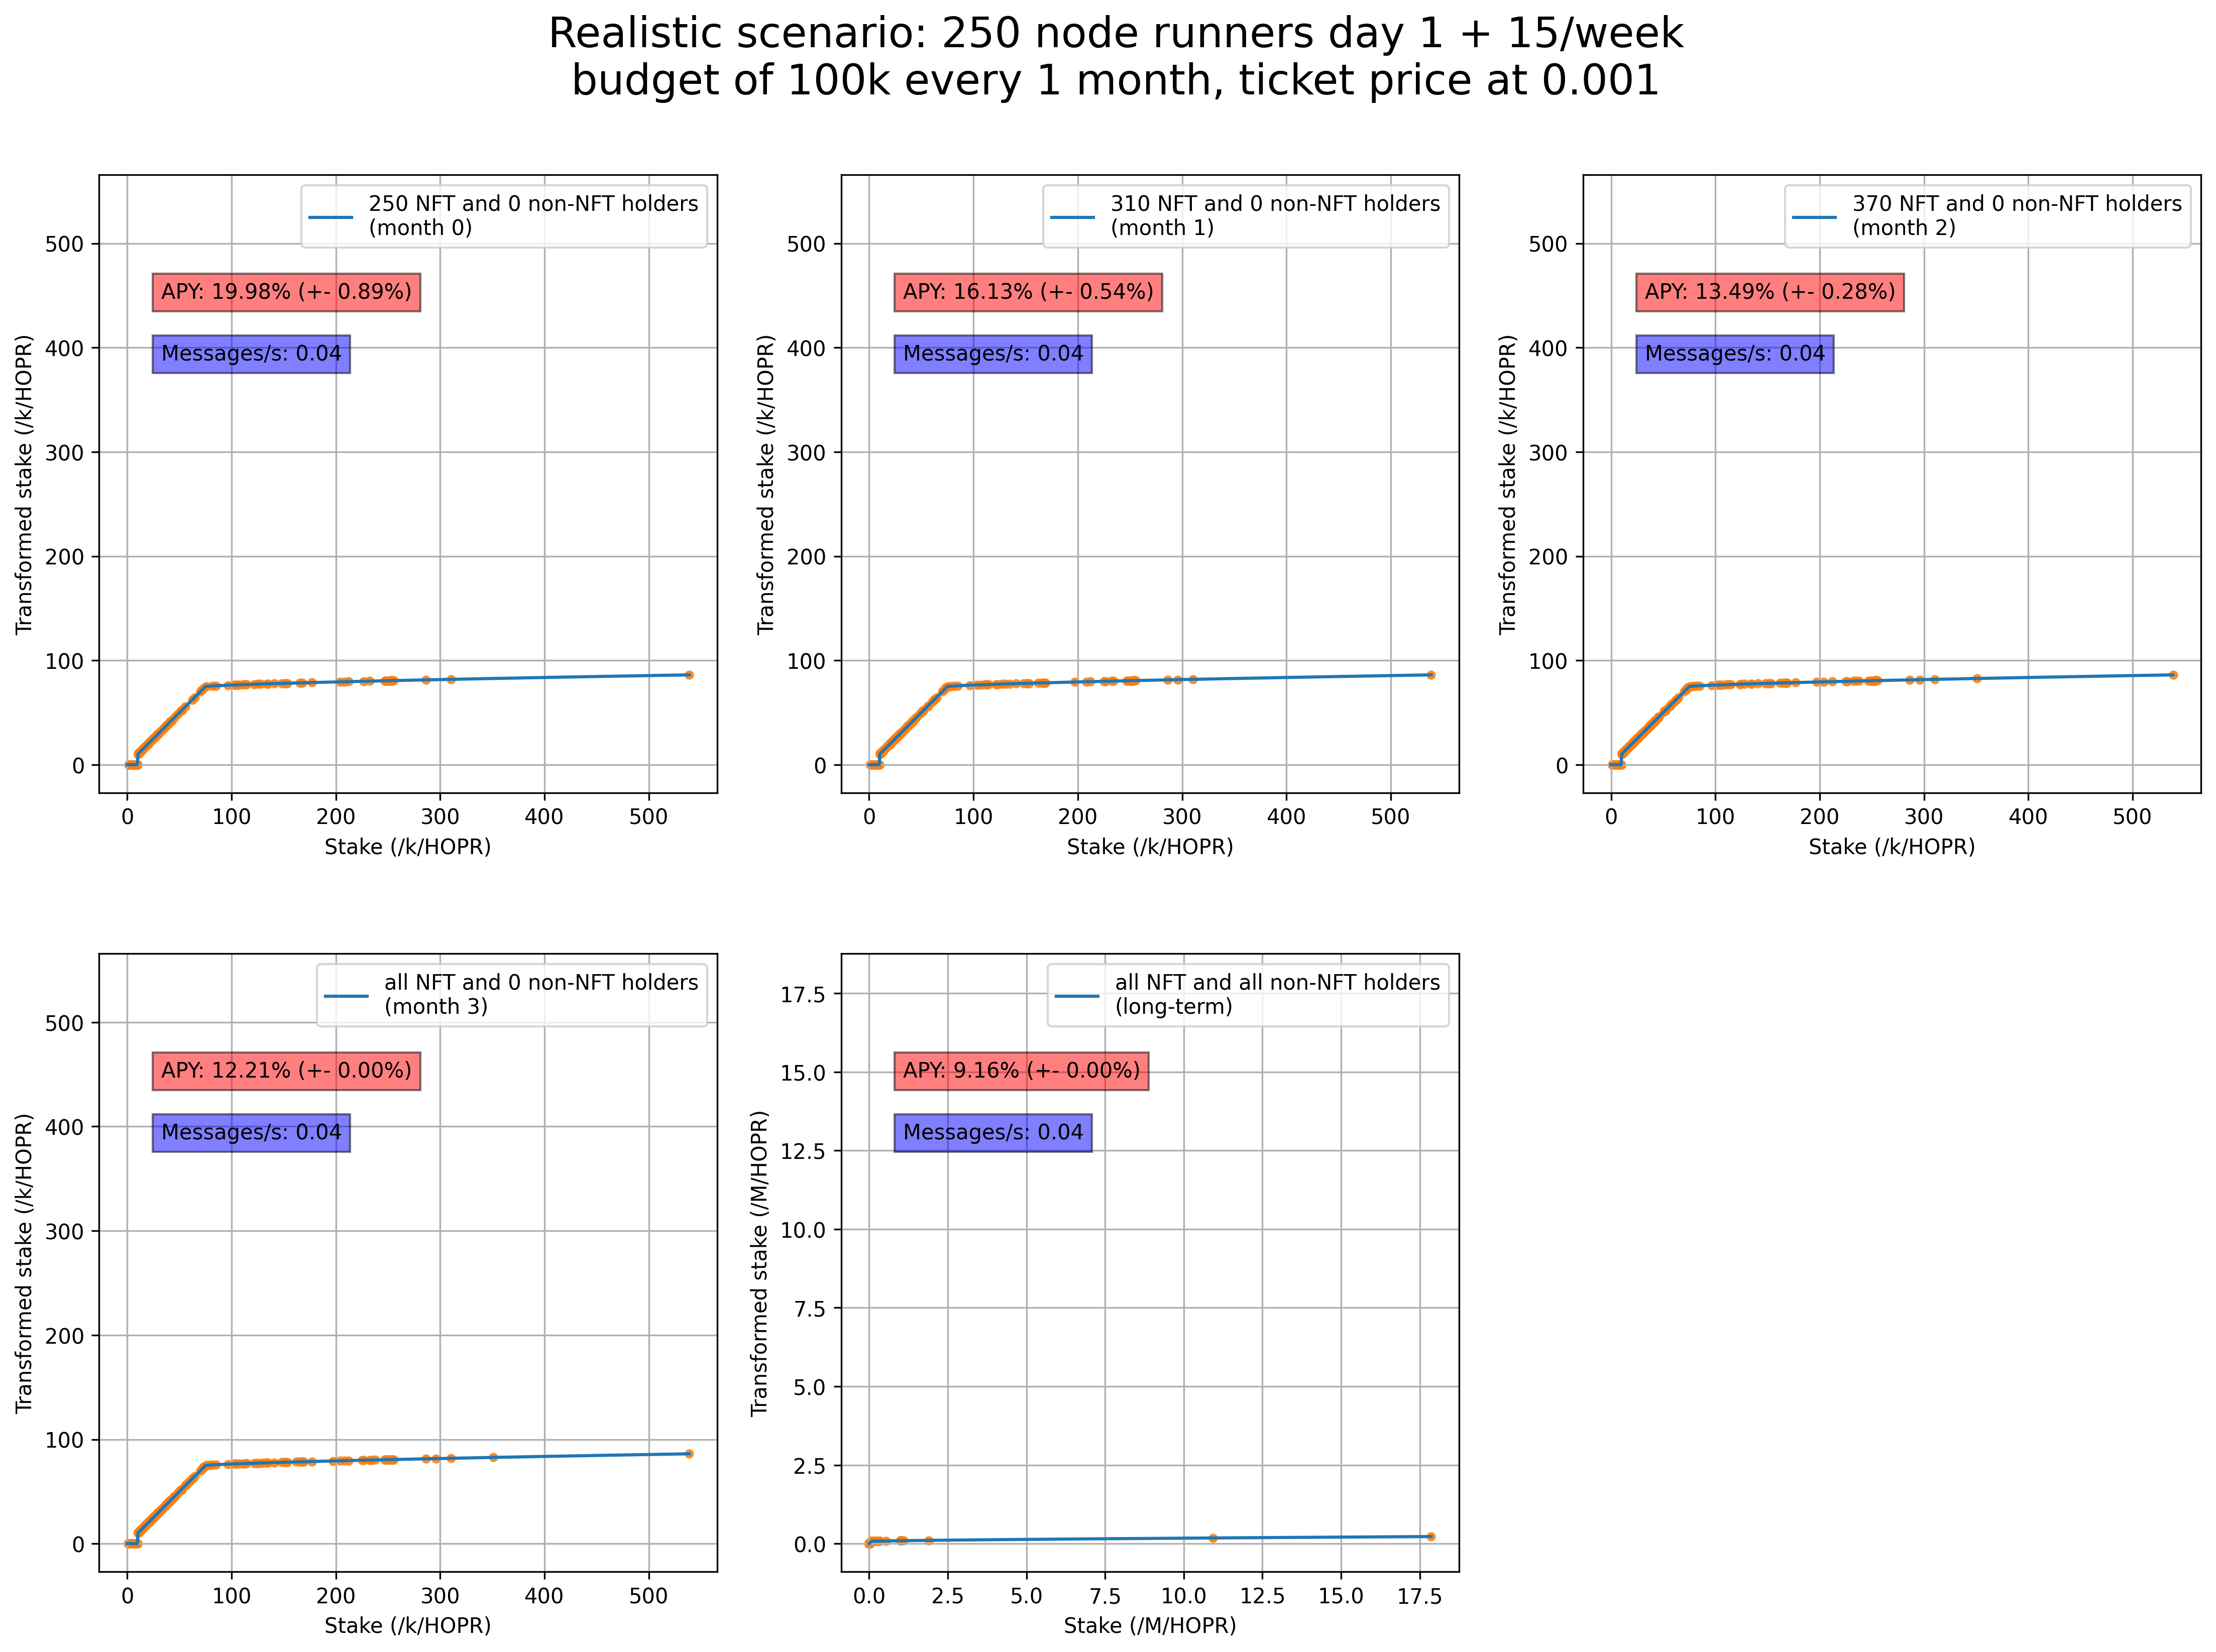

In [13]:
prefered_vars = [deepcopy(prefered) for _ in range(5)]

prefered_vars[0]["data_count"] = [250, 0, 0]
prefered_vars[1]["data_count"] = [310, 0, 0]
prefered_vars[2]["data_count"] = [370, 0, 0]
prefered_vars[3]["data_count"] = ["all", 0, 0]
prefered_vars[4]["data_count"] = ["all", "all", 0]

for idx, opt in enumerate(prefered_vars[:-1]):
    opt["legend"] = f"(month {idx})"

prefered_vars[-1]["legend"] = f"(long-term)"

for idx, opt in enumerate(prefered_vars):
    opt["legend"] = f"{opt['data_count'][0]} NFT and {opt['data_count'][1]} non-NFT holders\n{opt['legend']}"

generate_simulation_graph(datas, prefered_vars, title=f"Realistic scenario: 250 node runners day 1 + 15/week\nbudget of {prefered_vars[0]['budget']/1000:.0f}k every {prefered_vars[0]['period_in_months']} month, ticket price at 0.001")

Average APY: 11.864375273657851
Maximum APY: 11.864375273657854


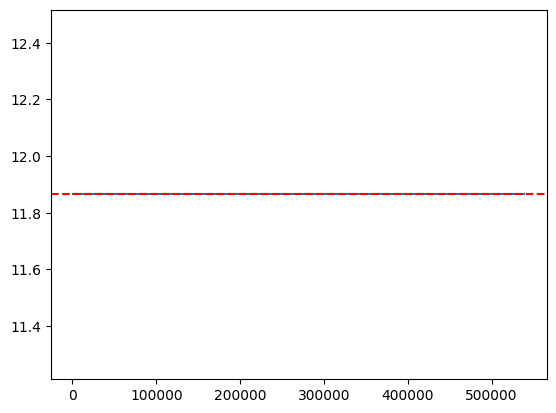

In [14]:
apys = compute_apy(prefered, staking_info_nft_holders, percentage=True, average=False)
average = np.mean([apy for apy, stake in zip(apys, staking_info_nft_holders) if stake > 10e3])

print(f"Average APY: {average}")
print(f"Maximum APY: {max(apys)}")

plt.plot(staking_info_nft_holders, apys)
plt.axhline(average, color="red", linestyle="--")
plt.show()


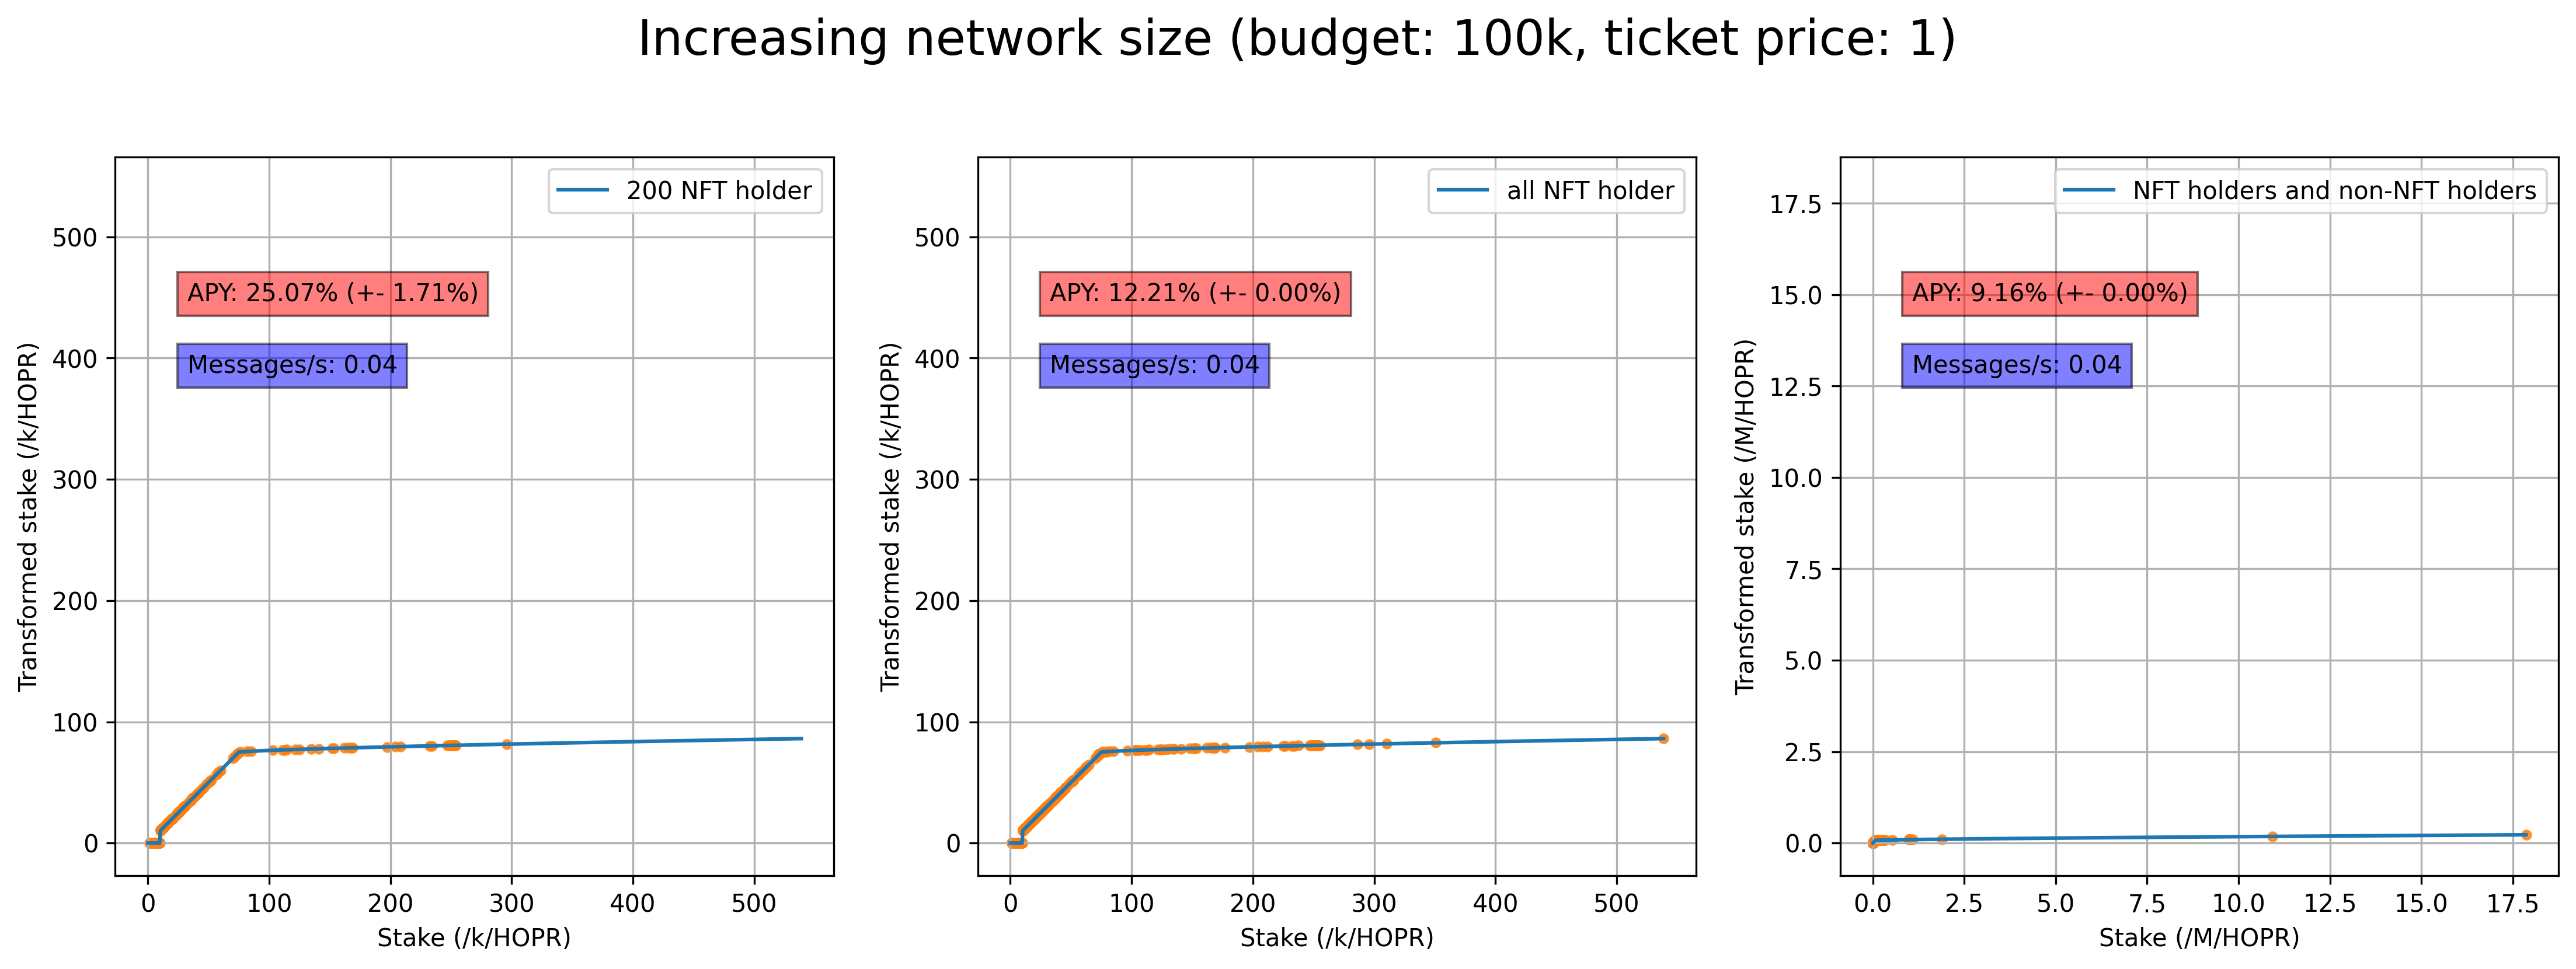

In [15]:
nft_holder_counts = [200, "all"]
options = [deepcopy(prefered) for _ in range(len(nft_holder_counts))]

for opt, count in zip(options, nft_holder_counts):
    opt["data_count"][0] = count
    opt["legend"] = f"{count} NFT holder"

options.append(deepcopy(prefered))

options[-1]["data_count"] = ["all", "all", 0]
options[-1]["legend"] = "NFT holders and non-NFT holders"


generate_simulation_graph(datas, options, title=f"Increasing network size (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']})", cols=3)

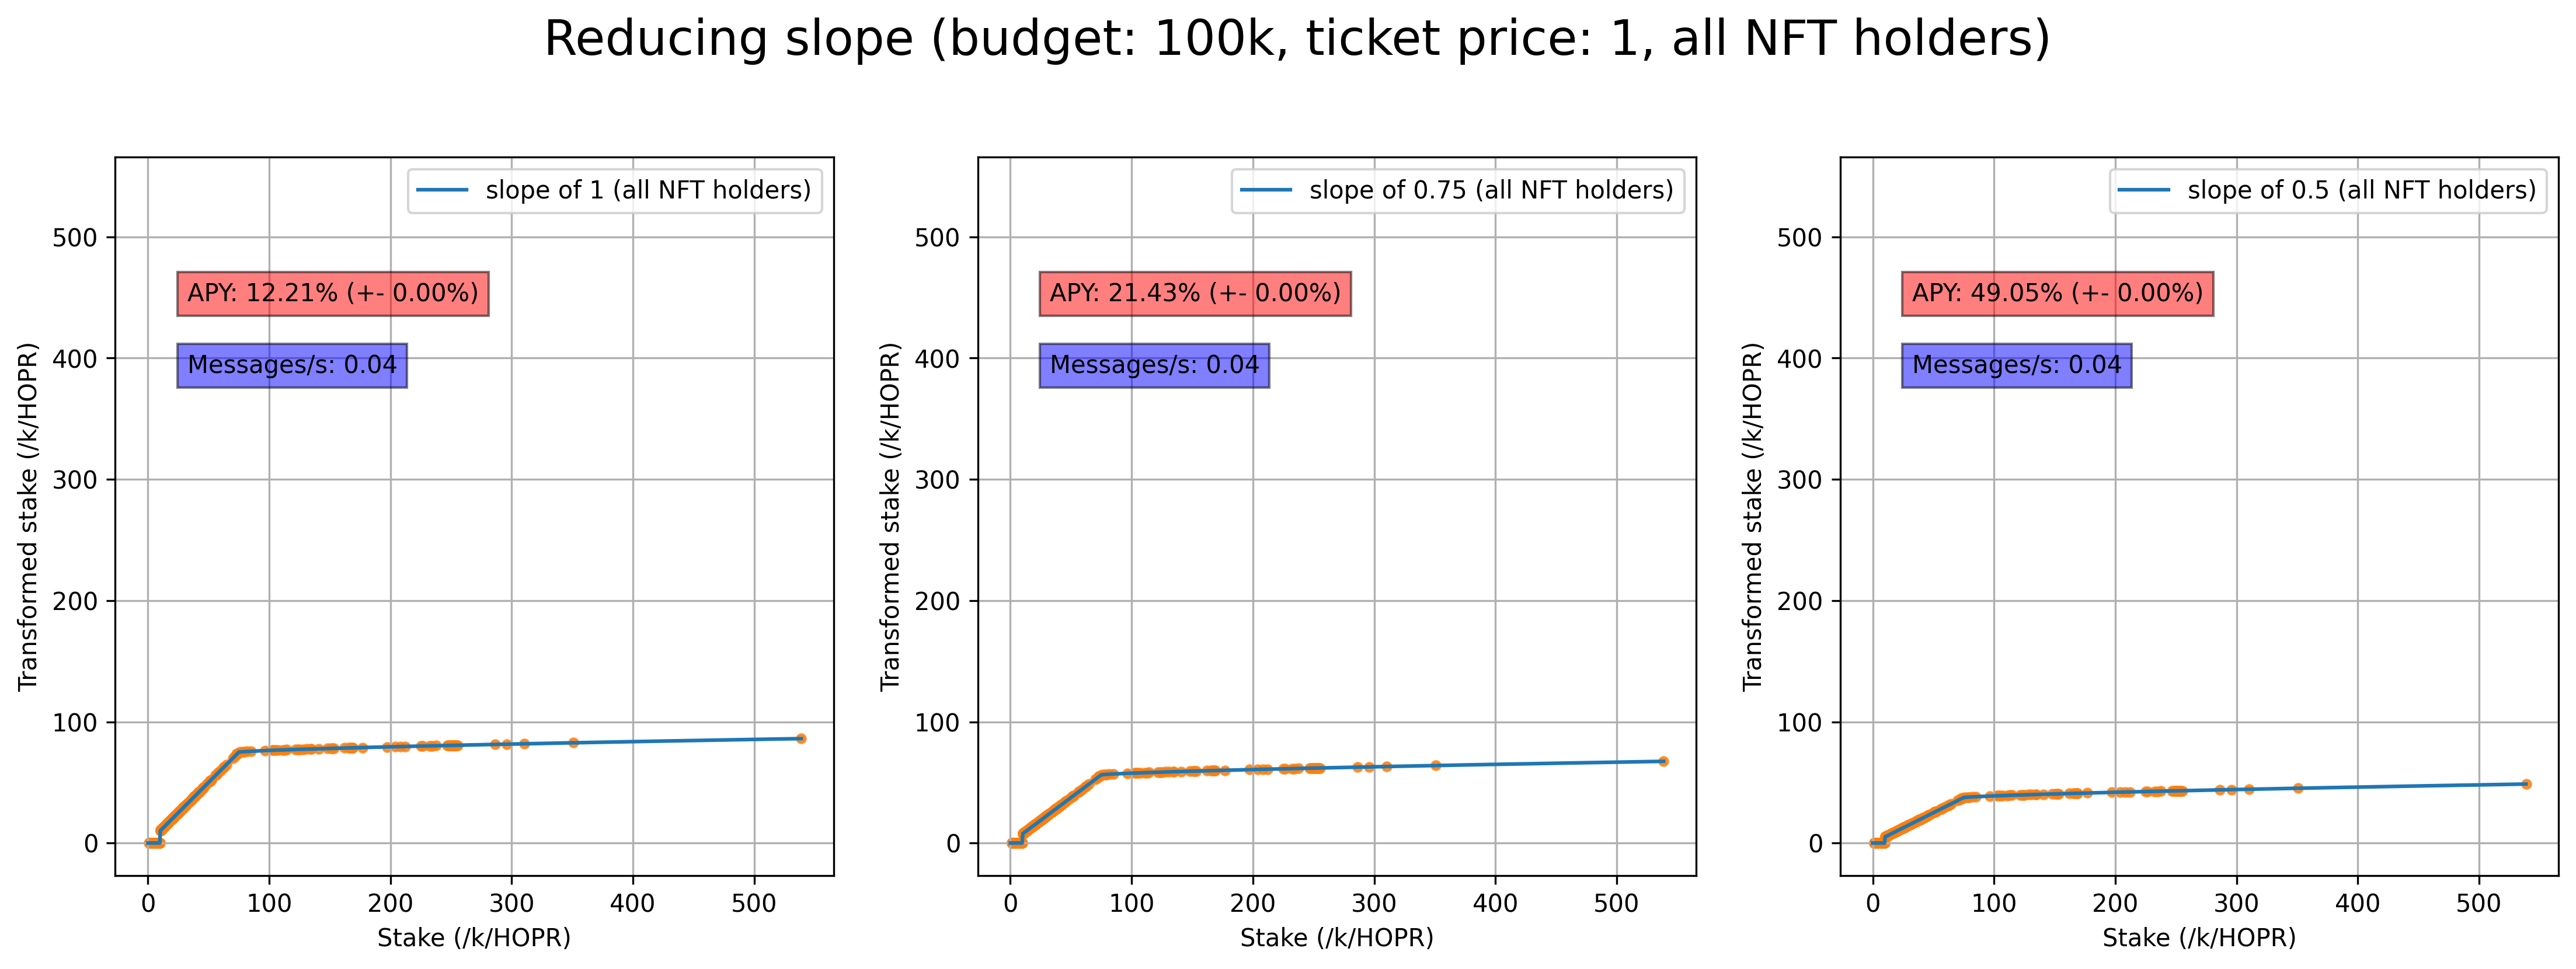

In [16]:
slopes = [1, 0.75, 0.5]
options_nft = [deepcopy(prefered) for _ in range(len(slopes))]

for opt_nft, slope in zip( options_nft, slopes):
    opt_nft["data_count"] = ["all", 0, 0]
    opt_nft["model_arguments"]["slope"] = slope
    opt_nft["legend"] = f"slope of {slope} (all NFT holders)"

generate_simulation_graph(datas, options_nft, 200, title=f"Reducing slope (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

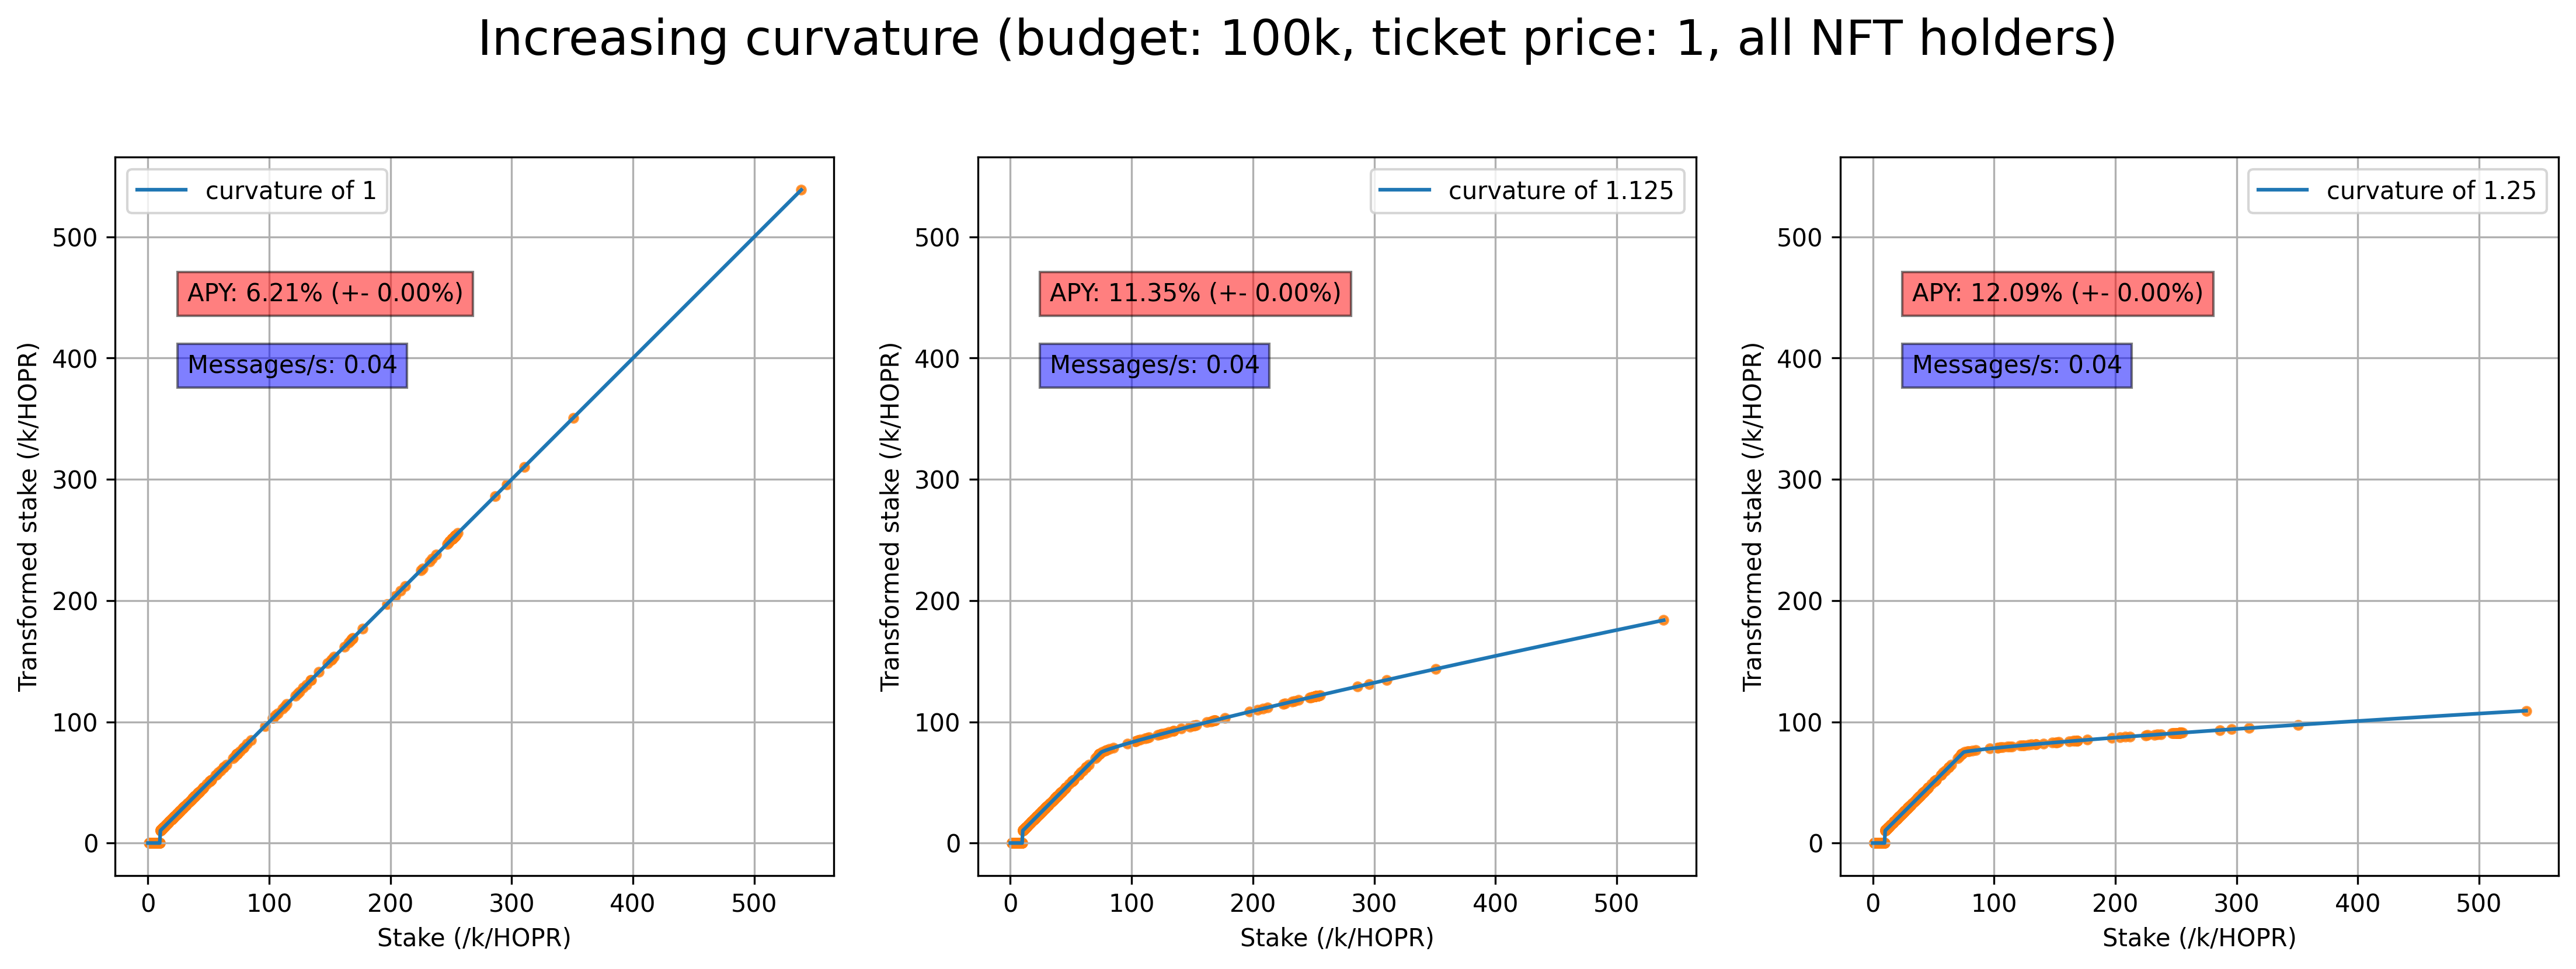

In [17]:
curvatures = [1, 1.125, 1.25]
options = [deepcopy(prefered) for _ in range(len(curvatures))]

for opt, curvature in zip(options, curvatures):
    opt["model_arguments"]["curvature"] = curvature
    opt["legend"] = f"curvature of {curvature}"

generate_simulation_graph(datas, options, 200, title=f"Increasing curvature (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")



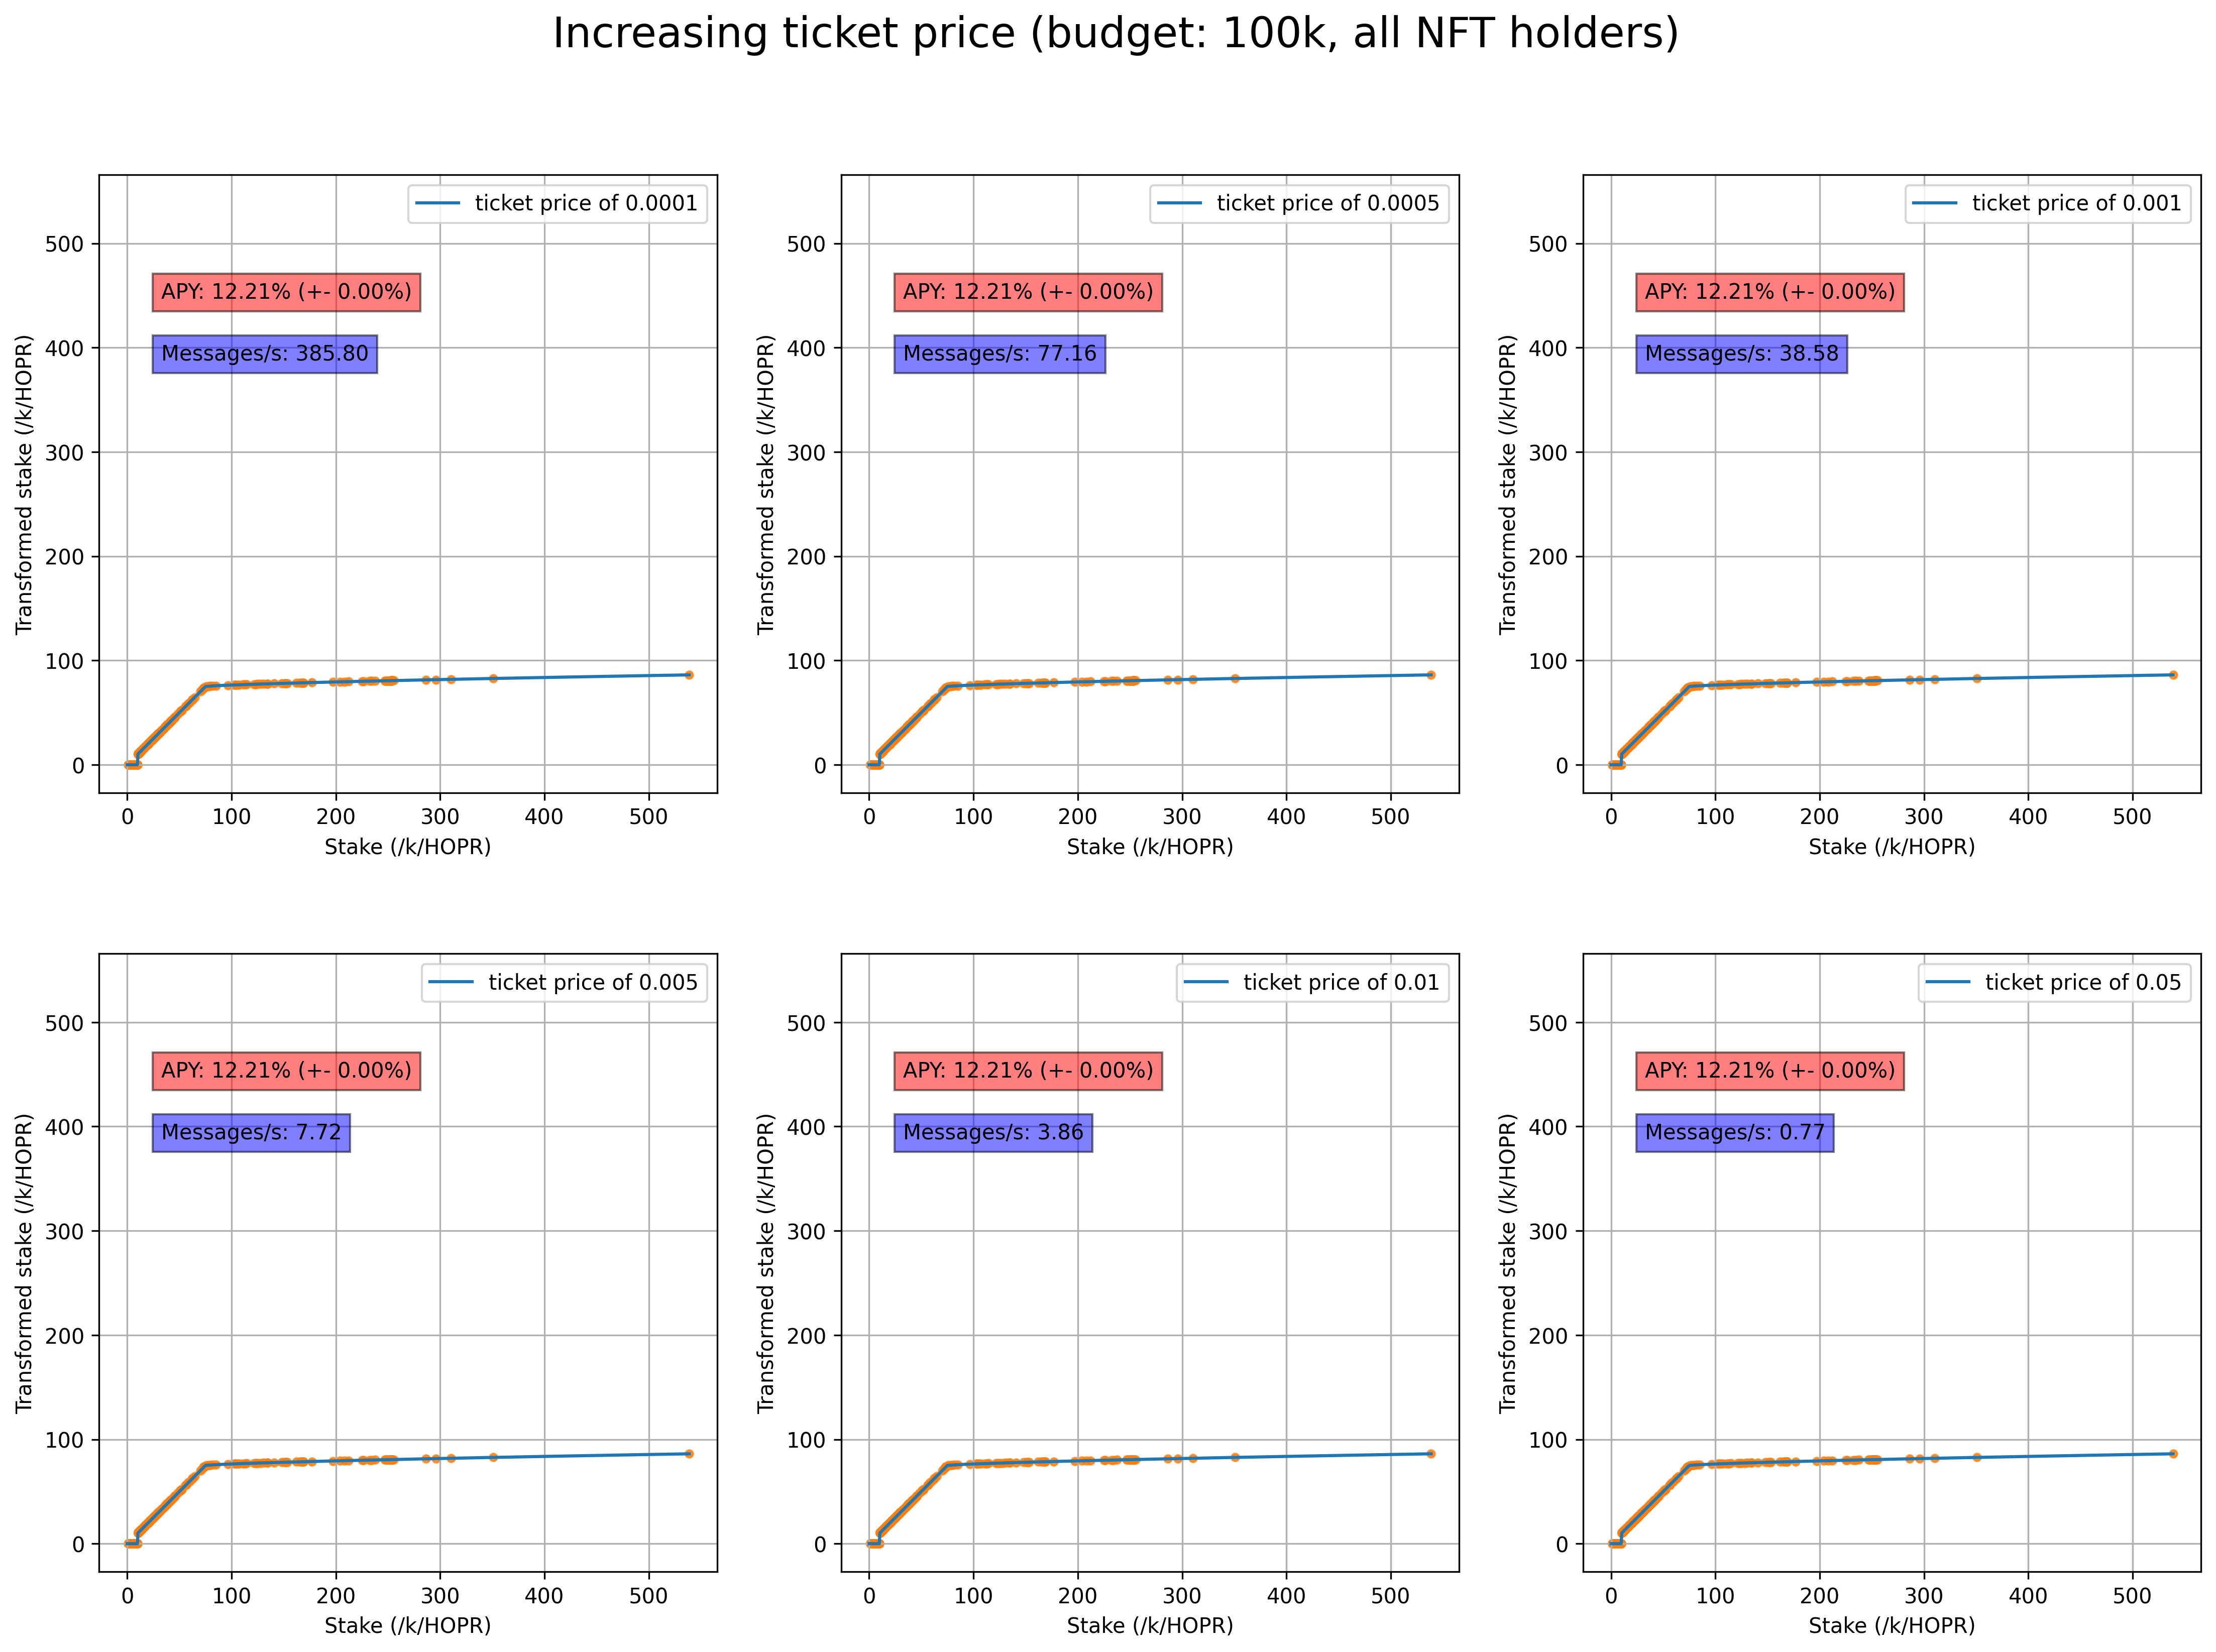

In [18]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, ticket_price in zip(options, ticket_prices):
    opt["ticket_options"]["price"] = ticket_price
    opt["legend"] = f"ticket price of {ticket_price}"

generate_simulation_graph(datas, options, title=f"Increasing ticket price (budget: {options[0]['budget']/1000:.0f}k, all NFT holders)")

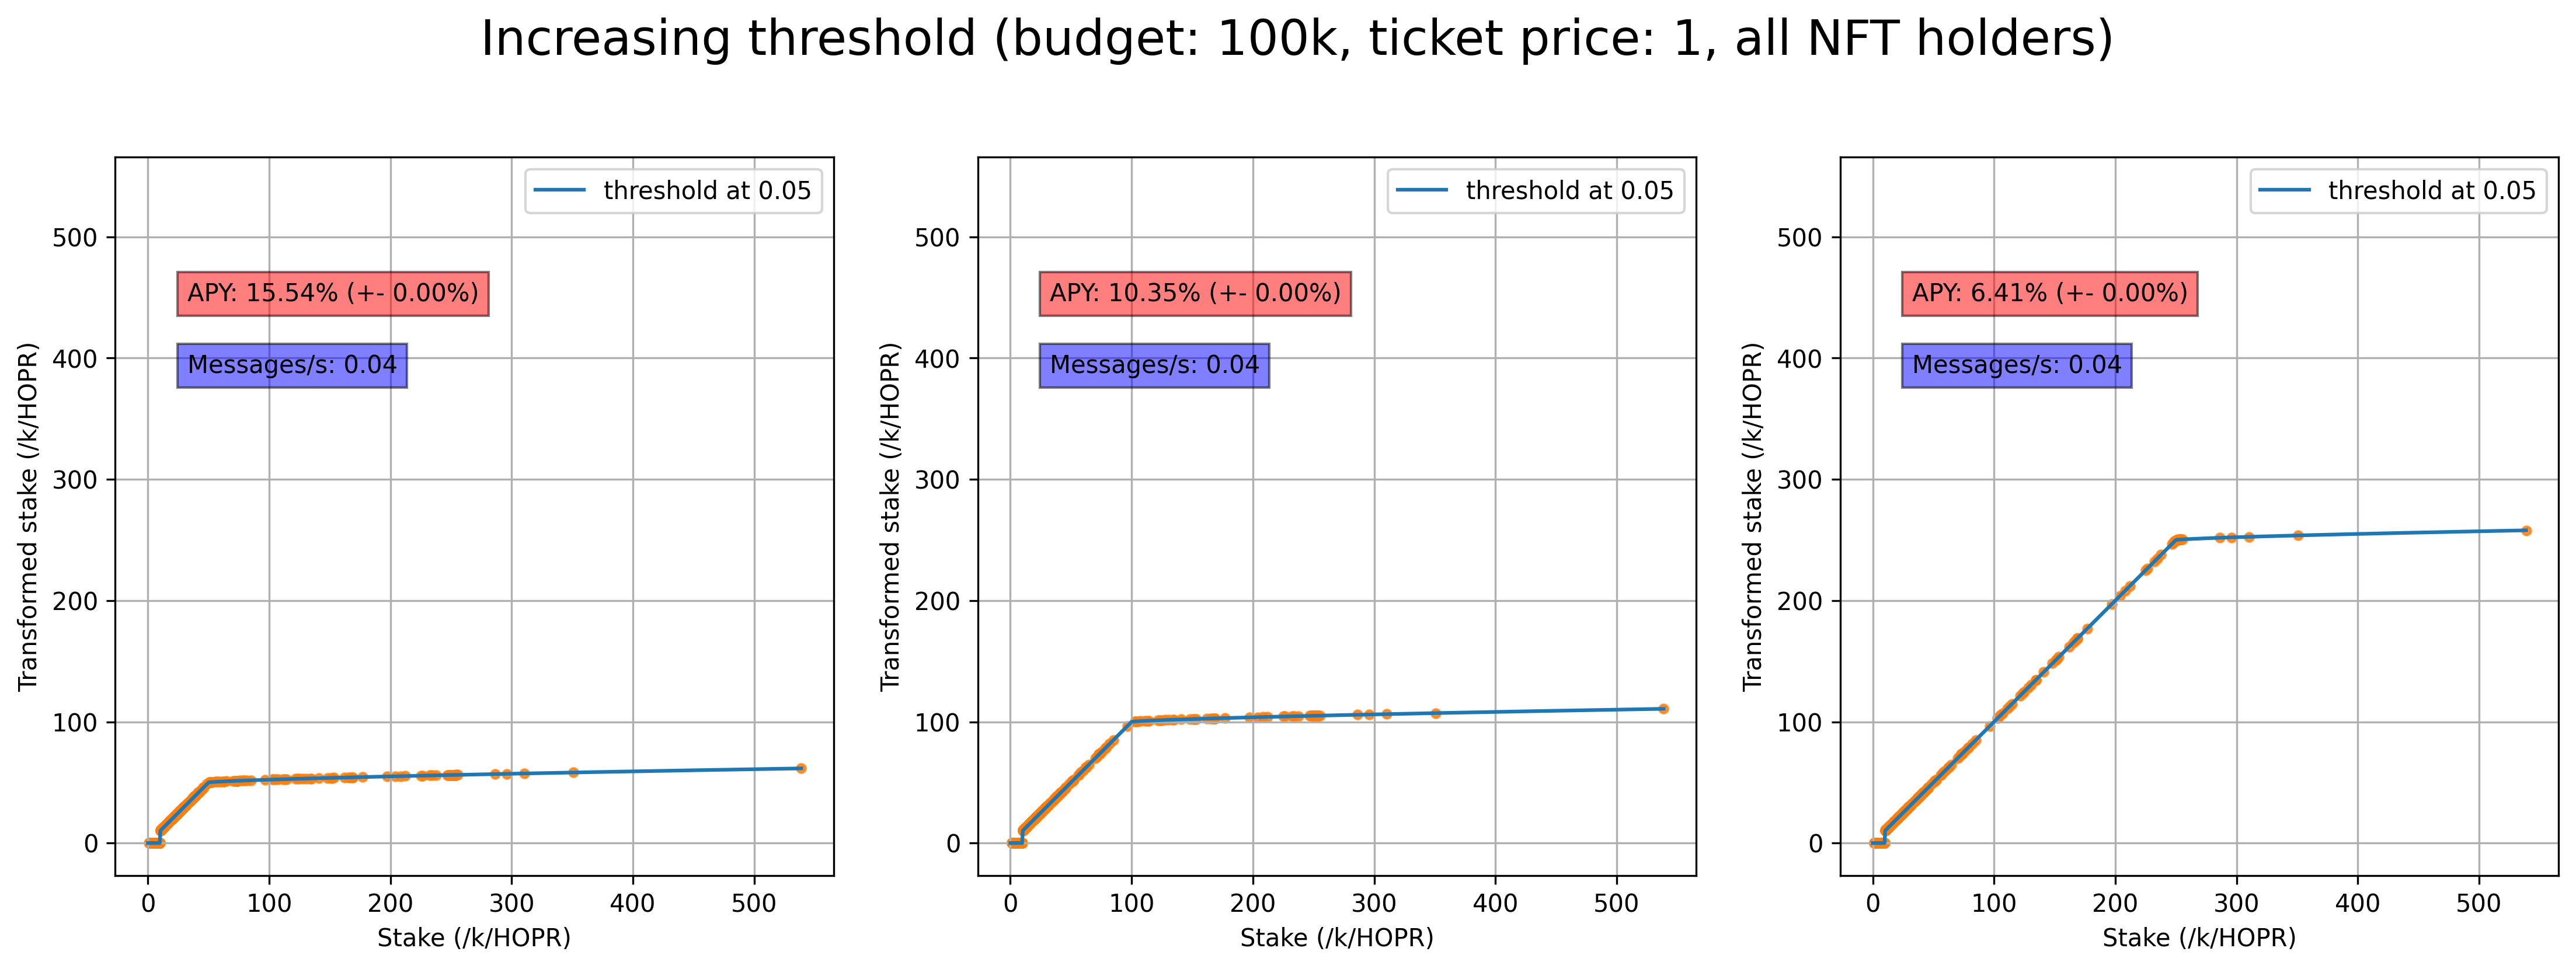

In [19]:
thresholds = [50e3, 100e3, 250e3]
options = [deepcopy(prefered) for _ in range(len(thresholds))]

for opt, threshold in zip(options, thresholds):
    opt["model_arguments"]["threshold"] = threshold
    opt["legend"] = f"threshold at {ticket_price}"


generate_simulation_graph(datas, options, title=f"Increasing threshold (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

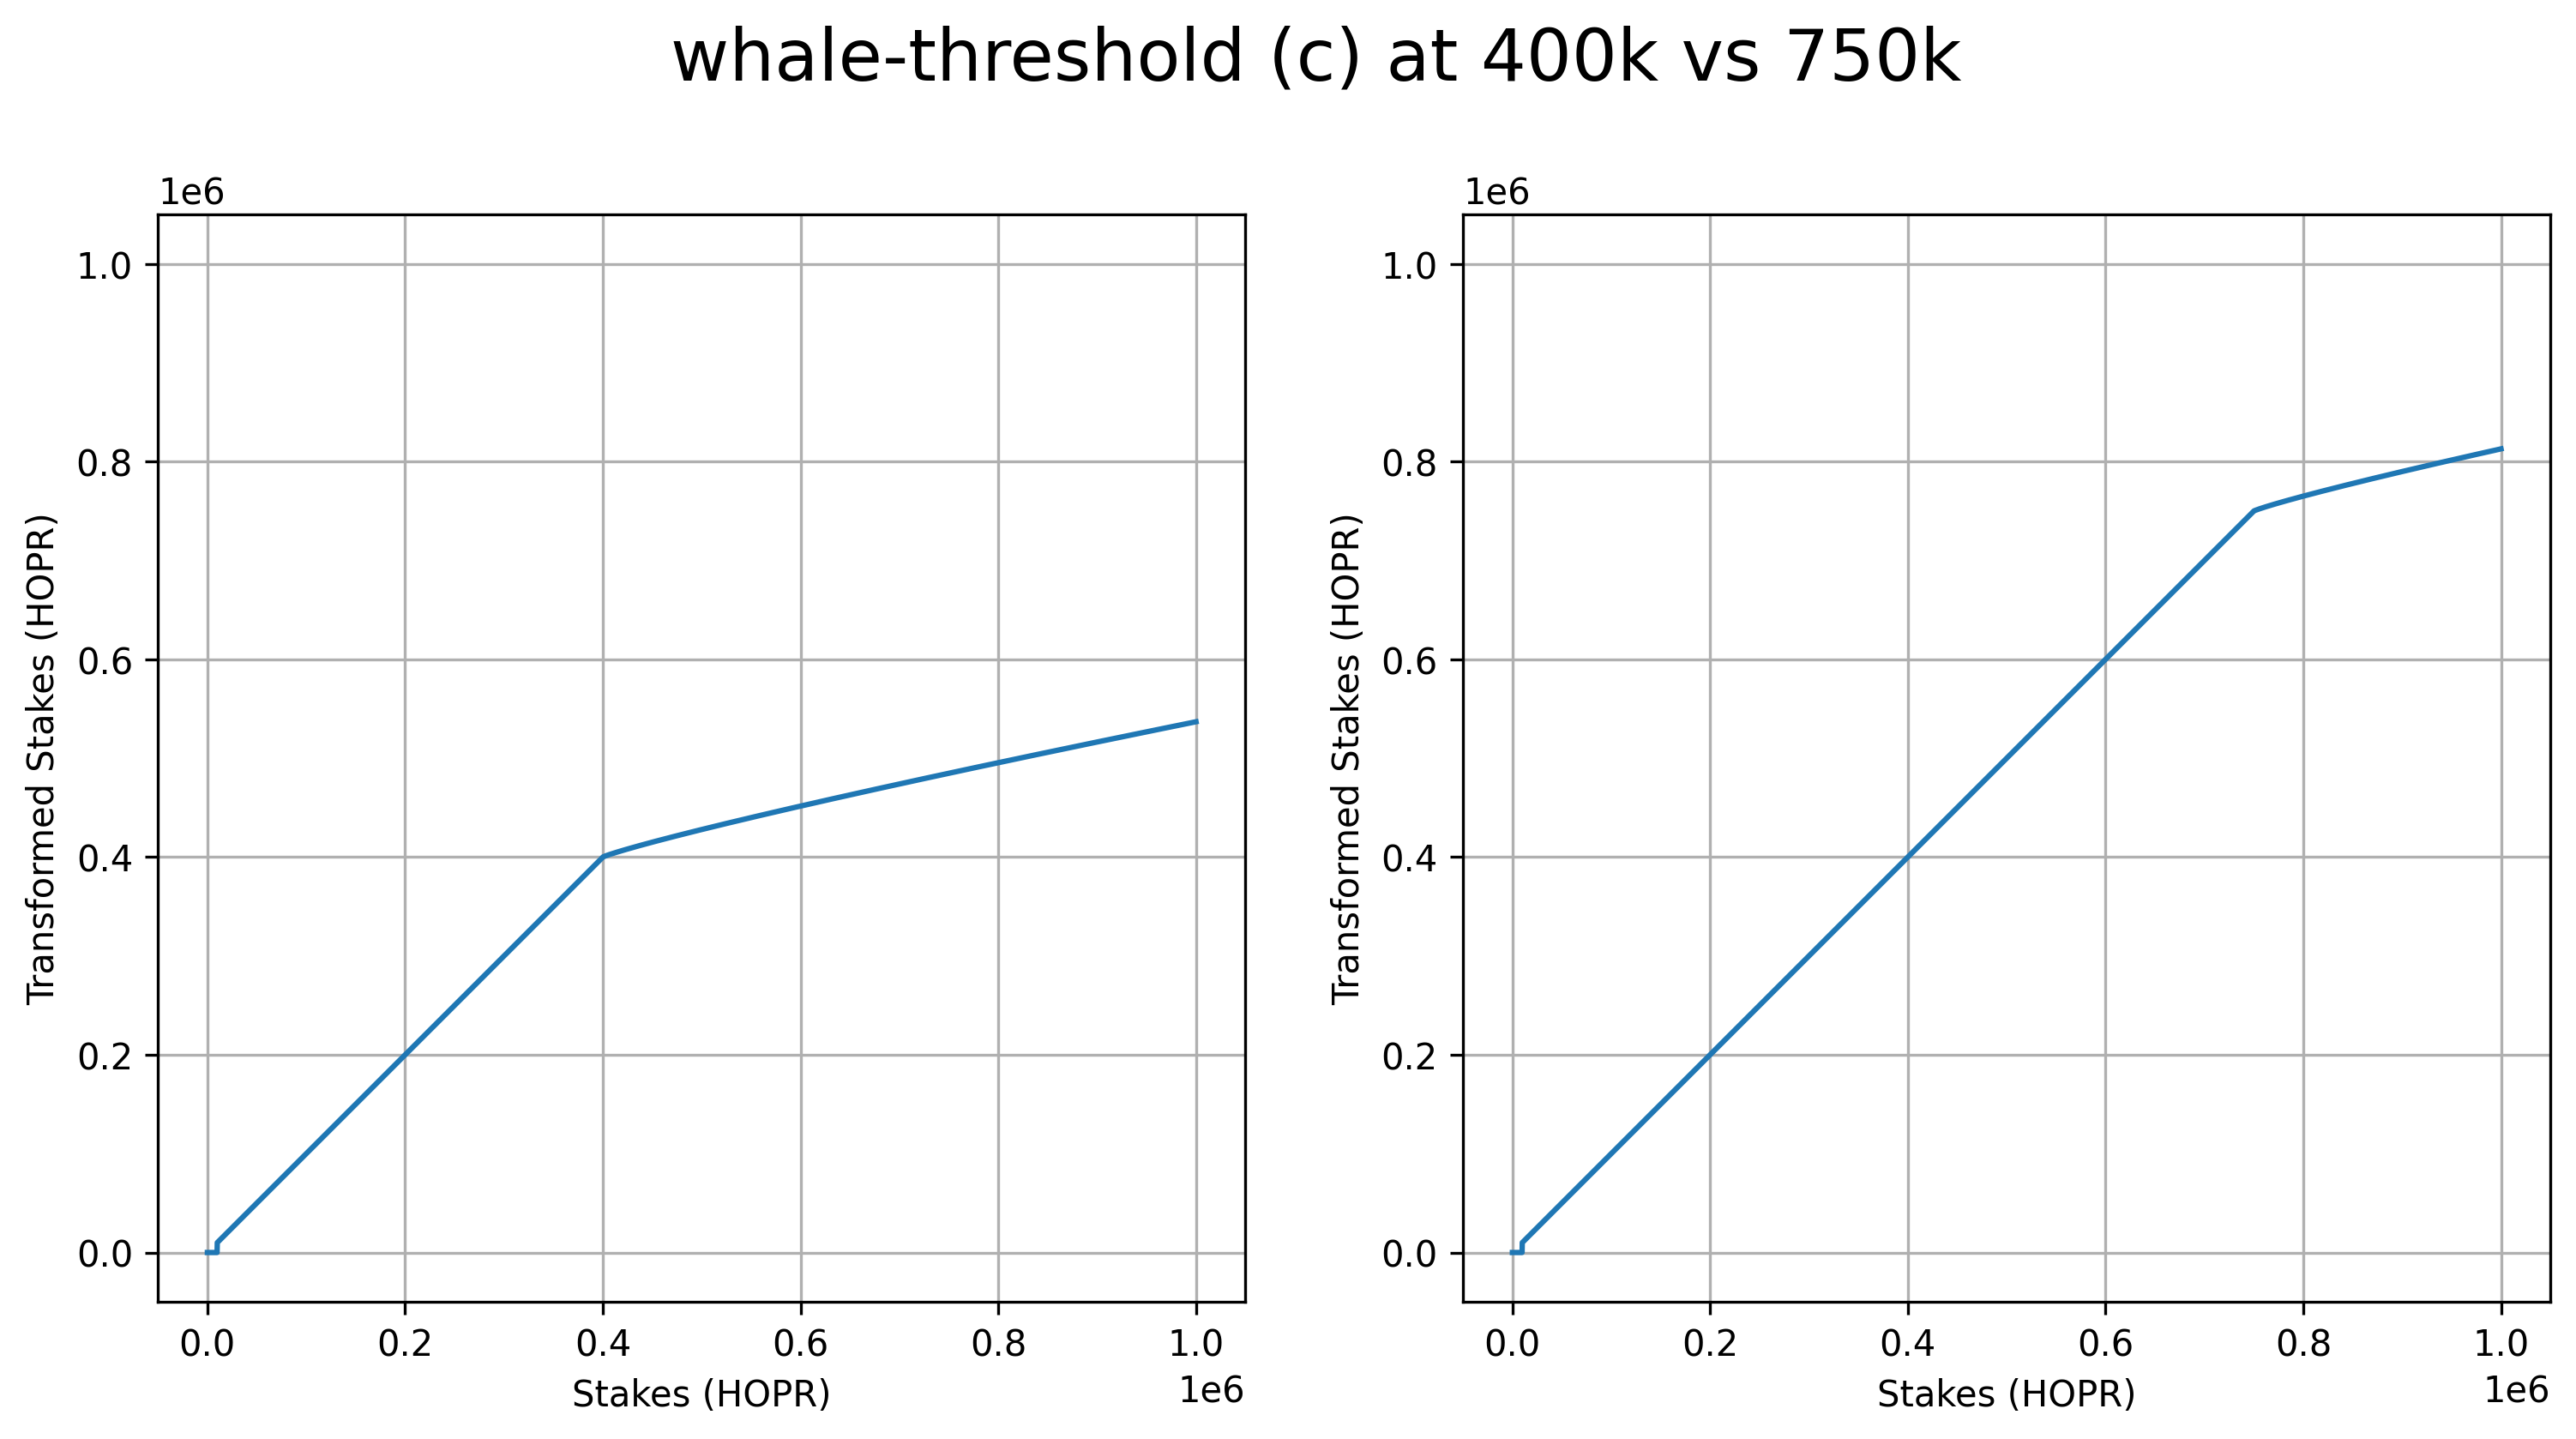

In [20]:
options = [{
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":750e3,
    }
}
]

generate_simulation_graph_simple(options, 5000, title="whale-threshold (c) at 400k vs 750k")

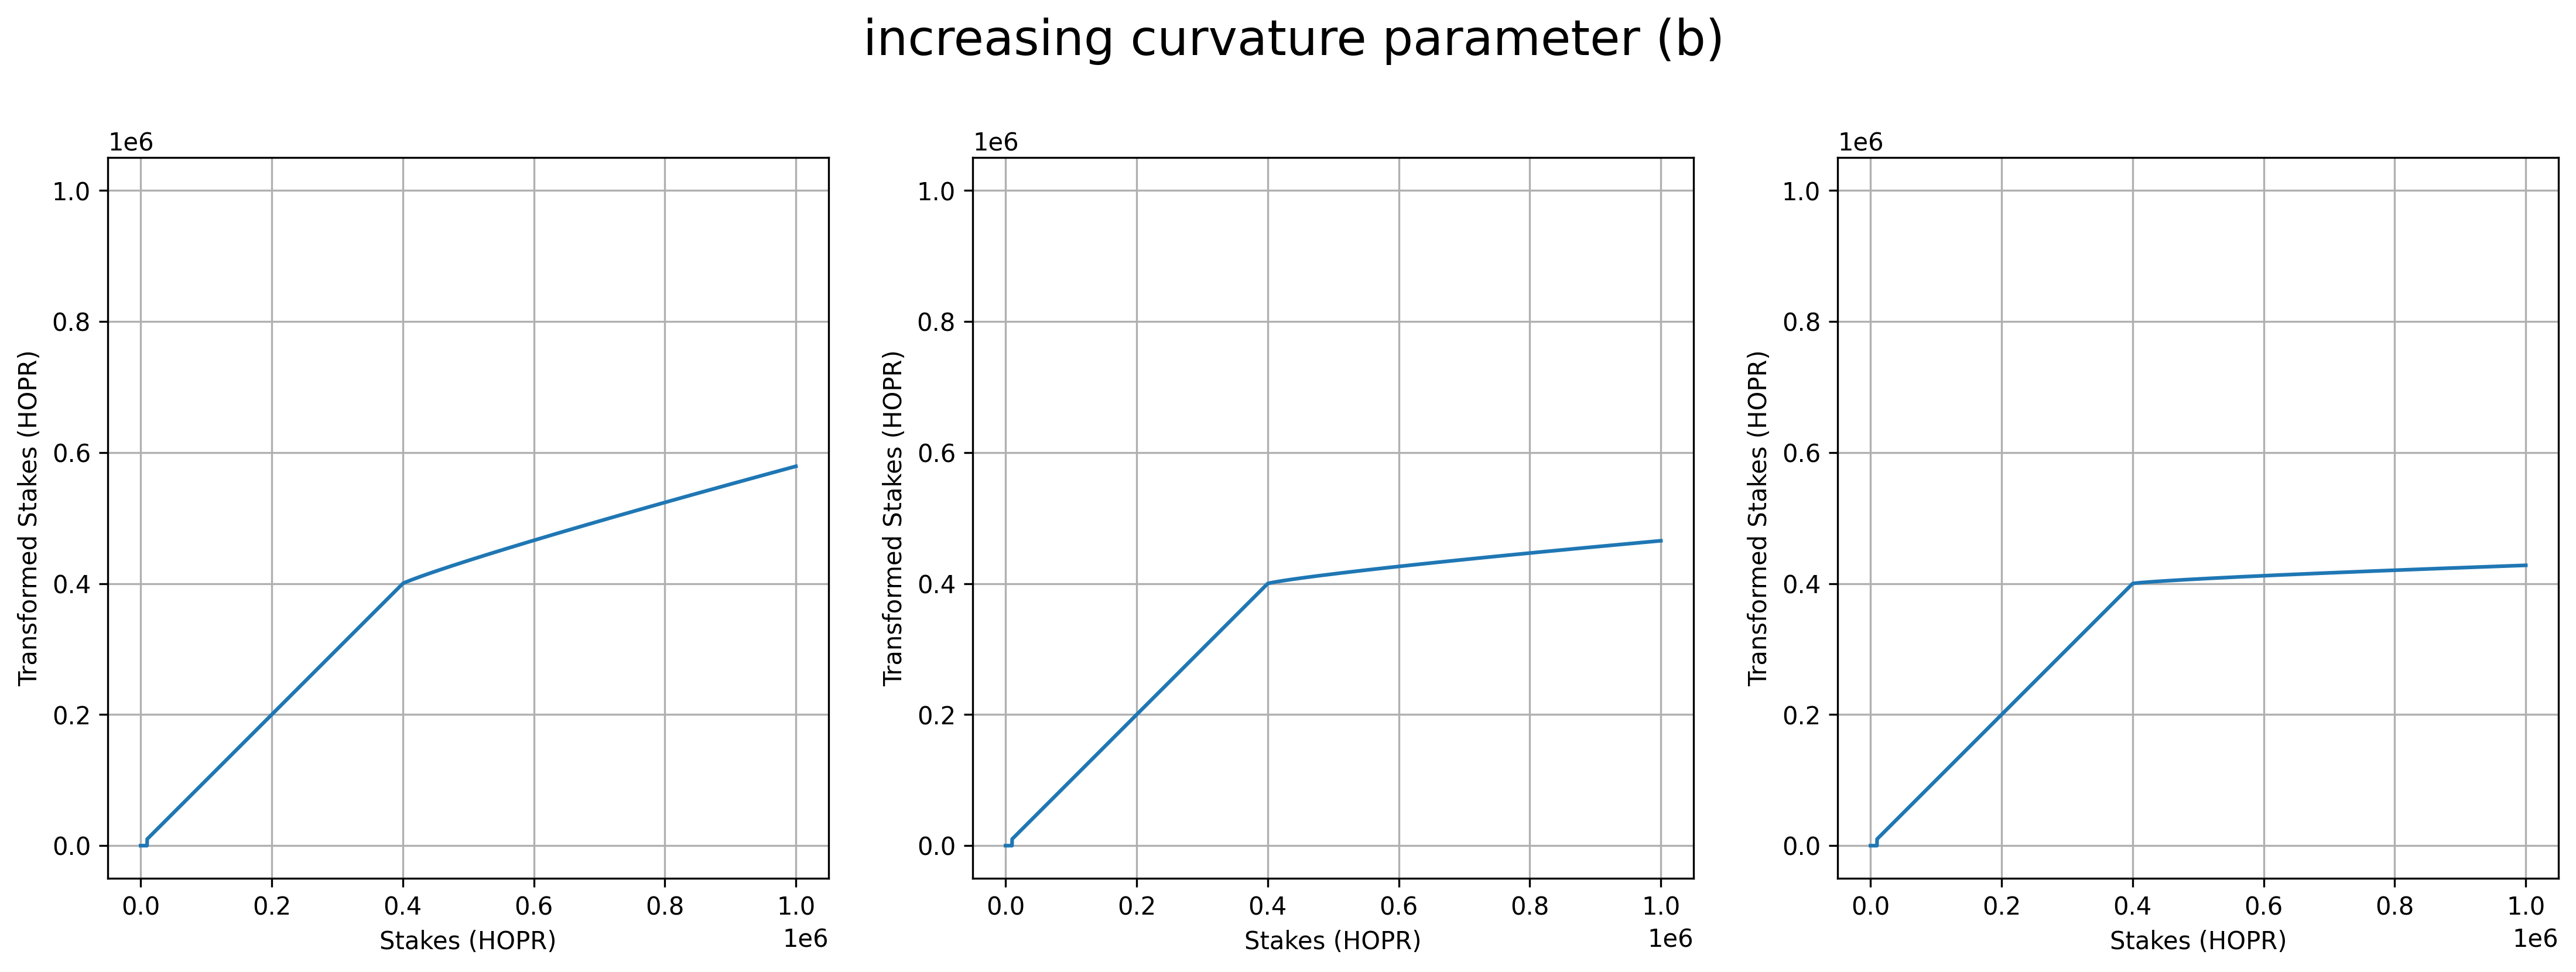

In [21]:
options = [{
    "model_arguments": {
        "slope": 1,
        "curvature":1.1,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.200,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.3,
        "threshold":400e3,
    }
}
]

generate_simulation_graph_simple(options, 5000, title="increasing curvature parameter (b)")

In [22]:
print(f"min stake: {min(staking_info_nft_holders):.2f} HOPR")
print(f"max stake: {max(staking_info_nft_holders):.2f} HOPR")
print(f"average stake: {np.mean(staking_info_nft_holders):.2f} HOPR")
print(f"median stake: {np.median(staking_info_nft_holders):.2f} HOPR")
print(f"total reward: {sum(list(raw_data[~condition]['rewards_till_now'])):.2f} HOPR")


min stake: 1000.51 HOPR
max stake: 538801.21 HOPR
average stake: 49534.33 HOPR
median stake: 11156.54 HOPR
total reward: 1020837.41 HOPR


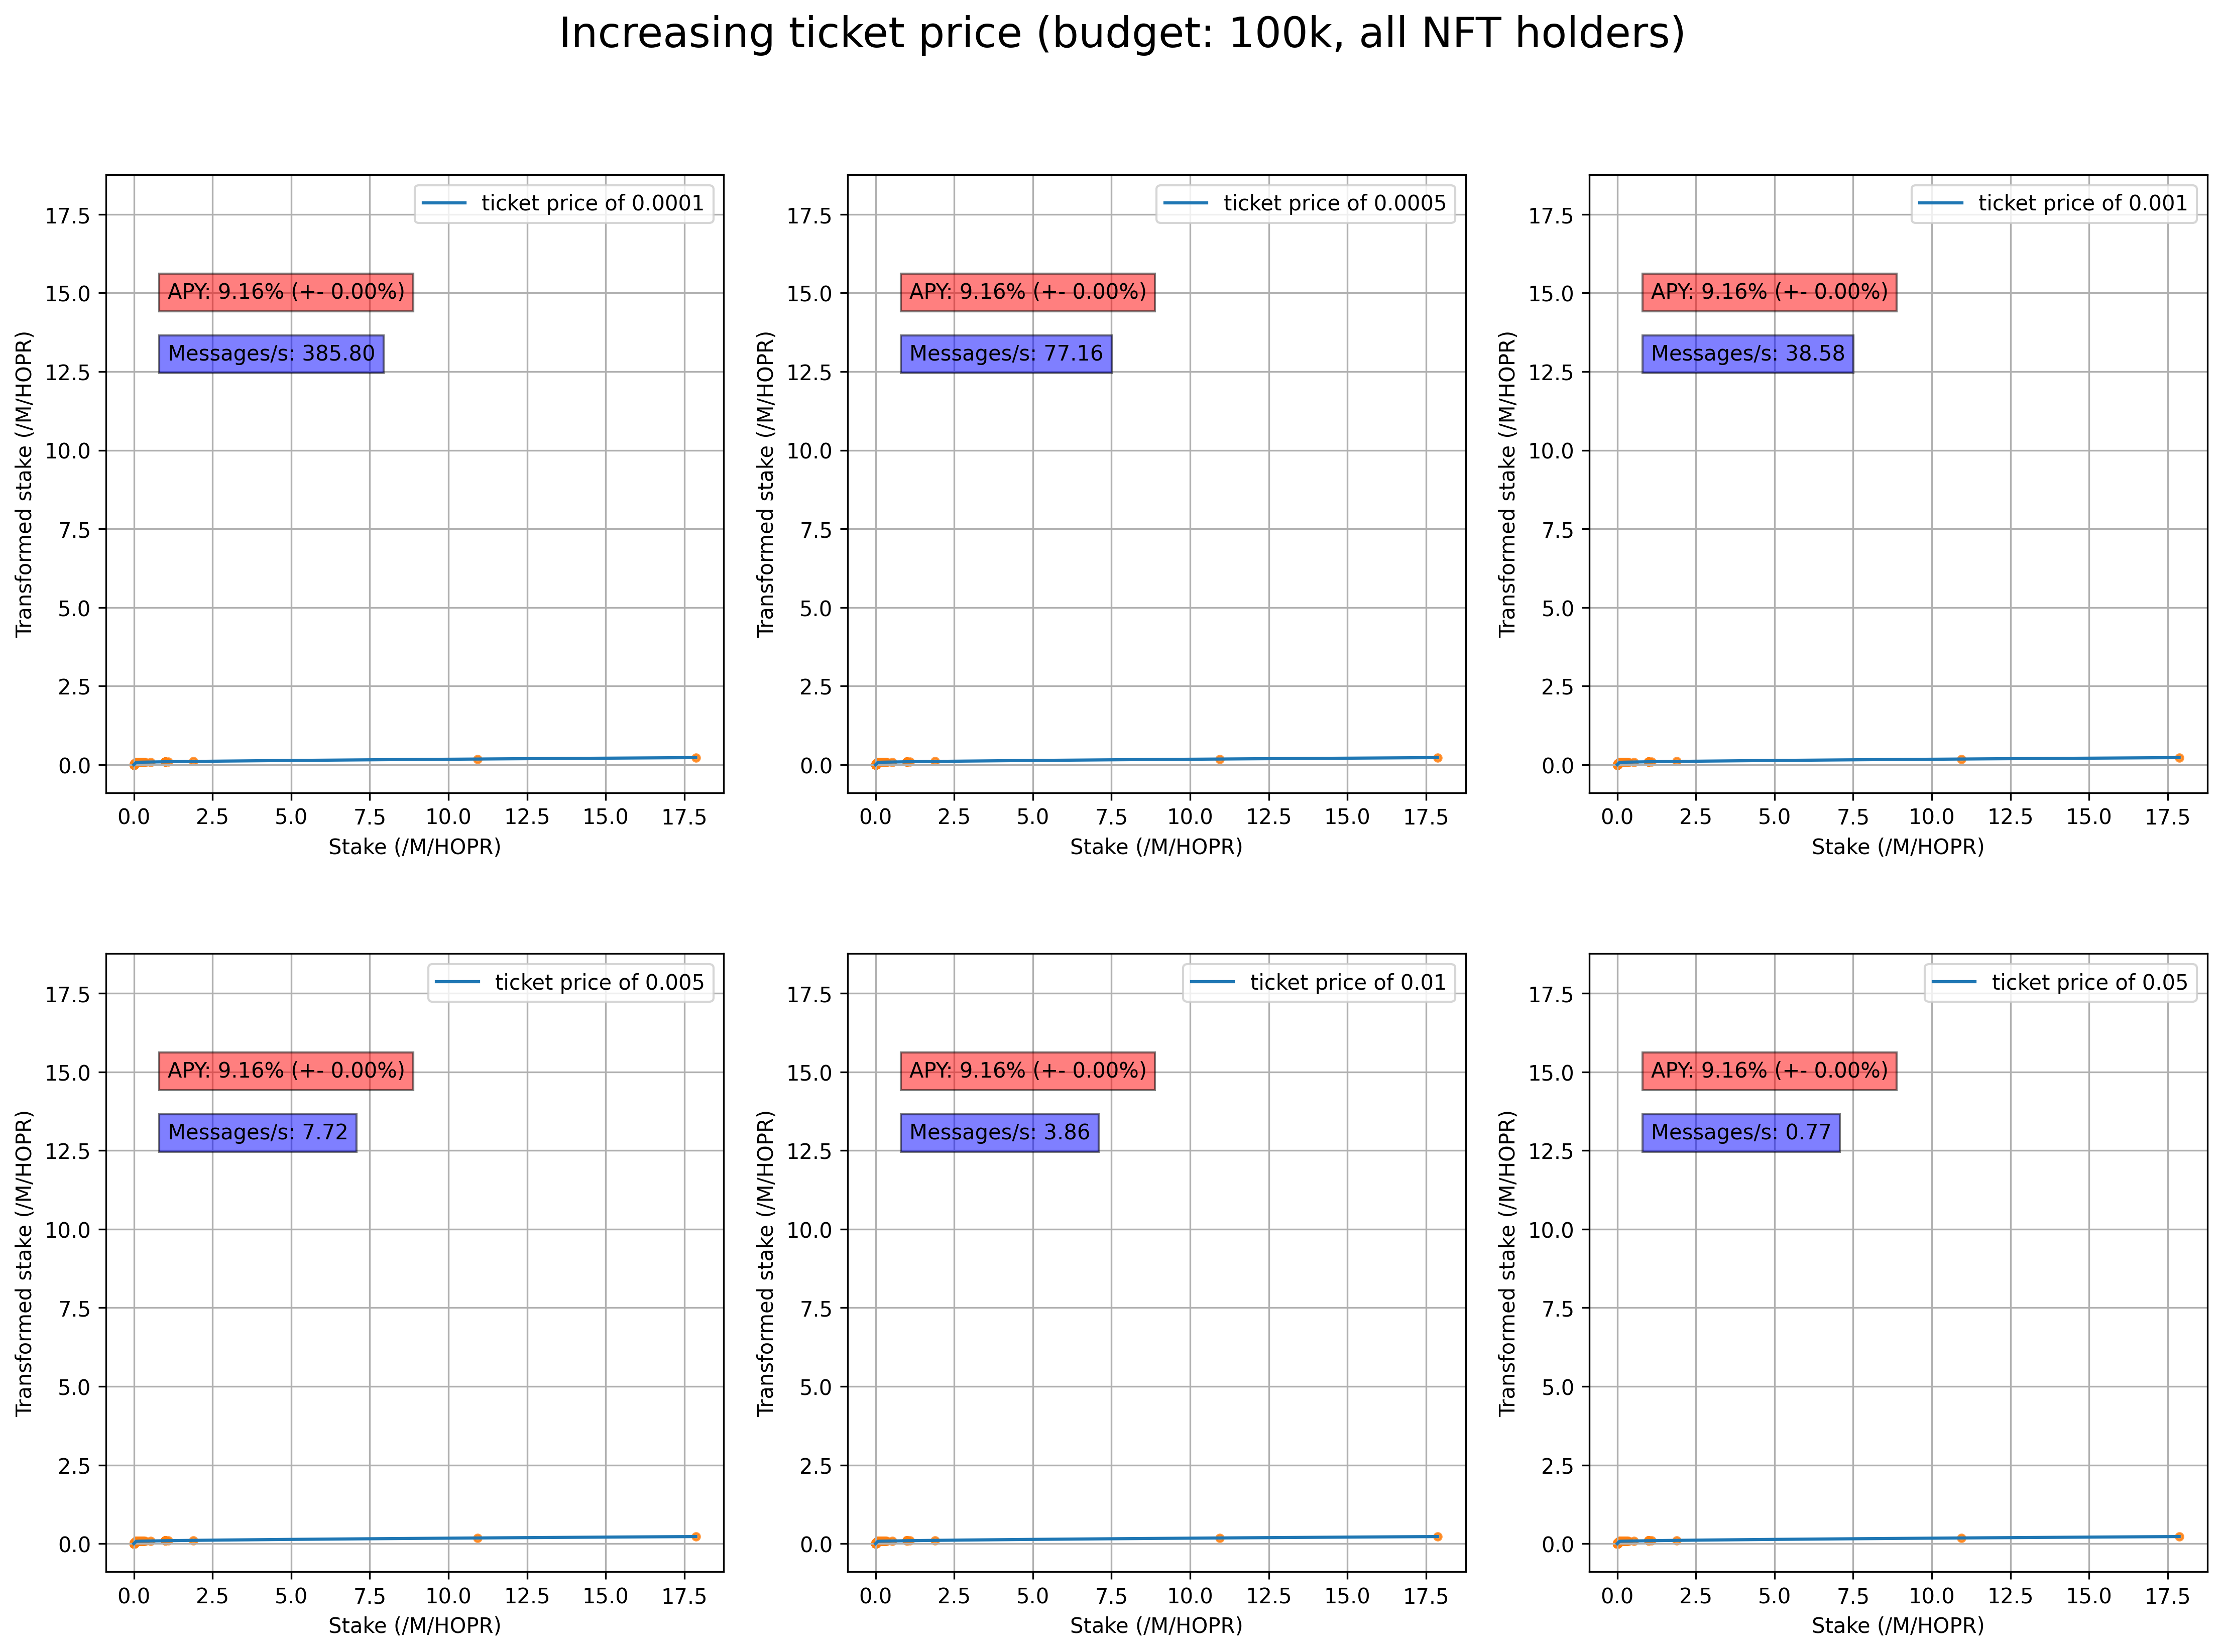

In [23]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, ticket_price in zip(options, ticket_prices):
    opt["data_count"] = ["all", "all", 0]
    opt["ticket_options"]["price"] = ticket_price
    opt["legend"] = f"ticket price of {ticket_price}"

generate_simulation_graph(datas, options, title=f"Increasing ticket price (budget: {options[0]['budget']/1000:.0f}k, all NFT holders)")

### Table results

In [24]:
counts = [
    [250, 0, 0],
    [310, 0, 0],
    [370, 0, 0],
    ["all", 0, 0],
    ["all", "all", 0],
]
columns = [f"{count[0]} NFT and {count[1]} non-NFT" for count in counts]

In [25]:
curvatures = [1, 1.125, 1.25, 1.375, 1.4, 1.5]
rows = [f"curvature: {curvature:.3f}" for curvature in curvatures]
options = [deepcopy(prefered) for _ in range(len(curvatures))]

for opt, curvature in zip(options, curvatures):
    opt["model_arguments"]["curvature"] = curvature

df_combined = pd.DataFrame(generate_simulation_table(datas, options, counts)[2], rows, columns)

display(df_combined)

250 NFT and 0 non-NFT 310 NFT and 0 non-NFT  \
curvature: 1.000      10.28% / 0.04m/s       8.24% / 0.04m/s   
curvature: 1.125      18.59% / 0.04m/s      15.07% / 0.04m/s   
curvature: 1.250      19.82% / 0.04m/s      15.96% / 0.04m/s   
curvature: 1.375      19.92% / 0.04m/s      16.11% / 0.04m/s   
curvature: 1.400      20.01% / 0.04m/s      16.04% / 0.04m/s   
curvature: 1.500      20.11% / 0.04m/s      16.14% / 0.04m/s   

                 370 NFT and 0 non-NFT all NFT and 0 non-NFT  \
curvature: 1.000       6.87% / 0.04m/s       6.21% / 0.04m/s   
curvature: 1.125      12.54% / 0.04m/s      11.35% / 0.04m/s   
curvature: 1.250      13.37% / 0.04m/s      12.09% / 0.04m/s   
curvature: 1.375      13.49% / 0.04m/s      12.20% / 0.04m/s   
curvature: 1.400      13.49% / 0.04m/s      12.21% / 0.04m/s   
curvature: 1.500      13.52% / 0.04m/s      12.23% / 0.04m/s   

                 all NFT and all non-NFT  
curvature: 1.000         1.96% / 0.04m/s  
curvature: 1.125         7.83% / 0.04m/s  
curvature: 1.250         9.00% / 0.04m/s  
curvature: 1.375         9.15% / 0.04m/s  
curvature: 1.400         9.16% / 0.04m/s  
curvature: 1.500         9.19% / 0.04m/s

In [26]:
thresholds = [50e3, 75e3, 100e3, 150e3, 250e3]
rows = [f"threshold: {int(threshold/1e3)}k" for threshold in thresholds]
options = [deepcopy(prefered) for _ in range(len(thresholds))]

for opt, threshold in zip(options, thresholds):
    opt["model_arguments"]["threshold"] = threshold

df_combined = pd.DataFrame(generate_simulation_table(datas, options, counts)[2], rows, columns)

display(df_combined)

250 NFT and 0 non-NFT 310 NFT and 0 non-NFT  \
threshold: 50k       25.58% / 0.04m/s      20.53% / 0.04m/s   
threshold: 75k       19.97% / 0.04m/s      16.08% / 0.04m/s   
threshold: 100k      16.95% / 0.04m/s      13.67% / 0.04m/s   
threshold: 150k      13.48% / 0.04m/s      10.91% / 0.04m/s   
threshold: 250k      10.58% / 0.04m/s       8.44% / 0.04m/s   

                370 NFT and 0 non-NFT all NFT and 0 non-NFT  \
threshold: 50k       17.18% / 0.04m/s      15.54% / 0.04m/s   
threshold: 75k       13.52% / 0.04m/s      12.21% / 0.04m/s   
threshold: 100k      11.42% / 0.04m/s      10.35% / 0.04m/s   
threshold: 150k       9.08% / 0.04m/s       8.23% / 0.04m/s   
threshold: 250k       7.10% / 0.04m/s       6.41% / 0.04m/s   

                all NFT and all non-NFT  
threshold: 50k         11.70% / 0.04m/s  
threshold: 75k          9.16% / 0.04m/s  
threshold: 100k         7.74% / 0.04m/s  
threshold: 150k         6.10% / 0.04m/s  
threshold: 250k         4.71% / 0.04m/s

In [27]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
rows = [f"ticket price: {price}" for price in ticket_prices]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, price in zip(options, ticket_prices):
    opt["ticket_options"]["price"] = price

df_combined = pd.DataFrame(generate_simulation_table(datas, options, counts)[2], rows, columns)

display(df_combined)

250 NFT and 0 non-NFT 310 NFT and 0 non-NFT  \
ticket price: 0.0001    20.04% / 385.80m/s    16.08% / 385.80m/s   
ticket price: 0.0005     19.94% / 77.16m/s     16.10% / 77.16m/s   
ticket price: 0.001      20.04% / 38.58m/s     16.12% / 38.58m/s   
ticket price: 0.005       20.00% / 7.72m/s      16.13% / 7.72m/s   
ticket price: 0.01        20.03% / 3.86m/s      16.14% / 3.86m/s   
ticket price: 0.05        19.98% / 0.77m/s      16.18% / 0.77m/s   

                     370 NFT and 0 non-NFT all NFT and 0 non-NFT  \
ticket price: 0.0001    13.51% / 385.80m/s    12.21% / 385.80m/s   
ticket price: 0.0005     13.50% / 77.16m/s     12.21% / 77.16m/s   
ticket price: 0.001      13.51% / 38.58m/s     12.21% / 38.58m/s   
ticket price: 0.005       13.48% / 7.72m/s      12.21% / 7.72m/s   
ticket price: 0.01        13.44% / 3.86m/s      12.21% / 3.86m/s   
ticket price: 0.05        13.50% / 0.77m/s      12.21% / 0.77m/s   

                     all NFT and all non-NFT  
ticket price: 0.0001       9.16% / 385.80m/s  
ticket price: 0.0005        9.16% / 77.16m/s  
ticket price: 0.001         9.16% / 38.58m/s  
ticket price: 0.005          9.16% / 7.72m/s  
ticket price: 0.01           9.16% / 3.86m/s  
ticket price: 0.05           9.16% / 0.77m/s

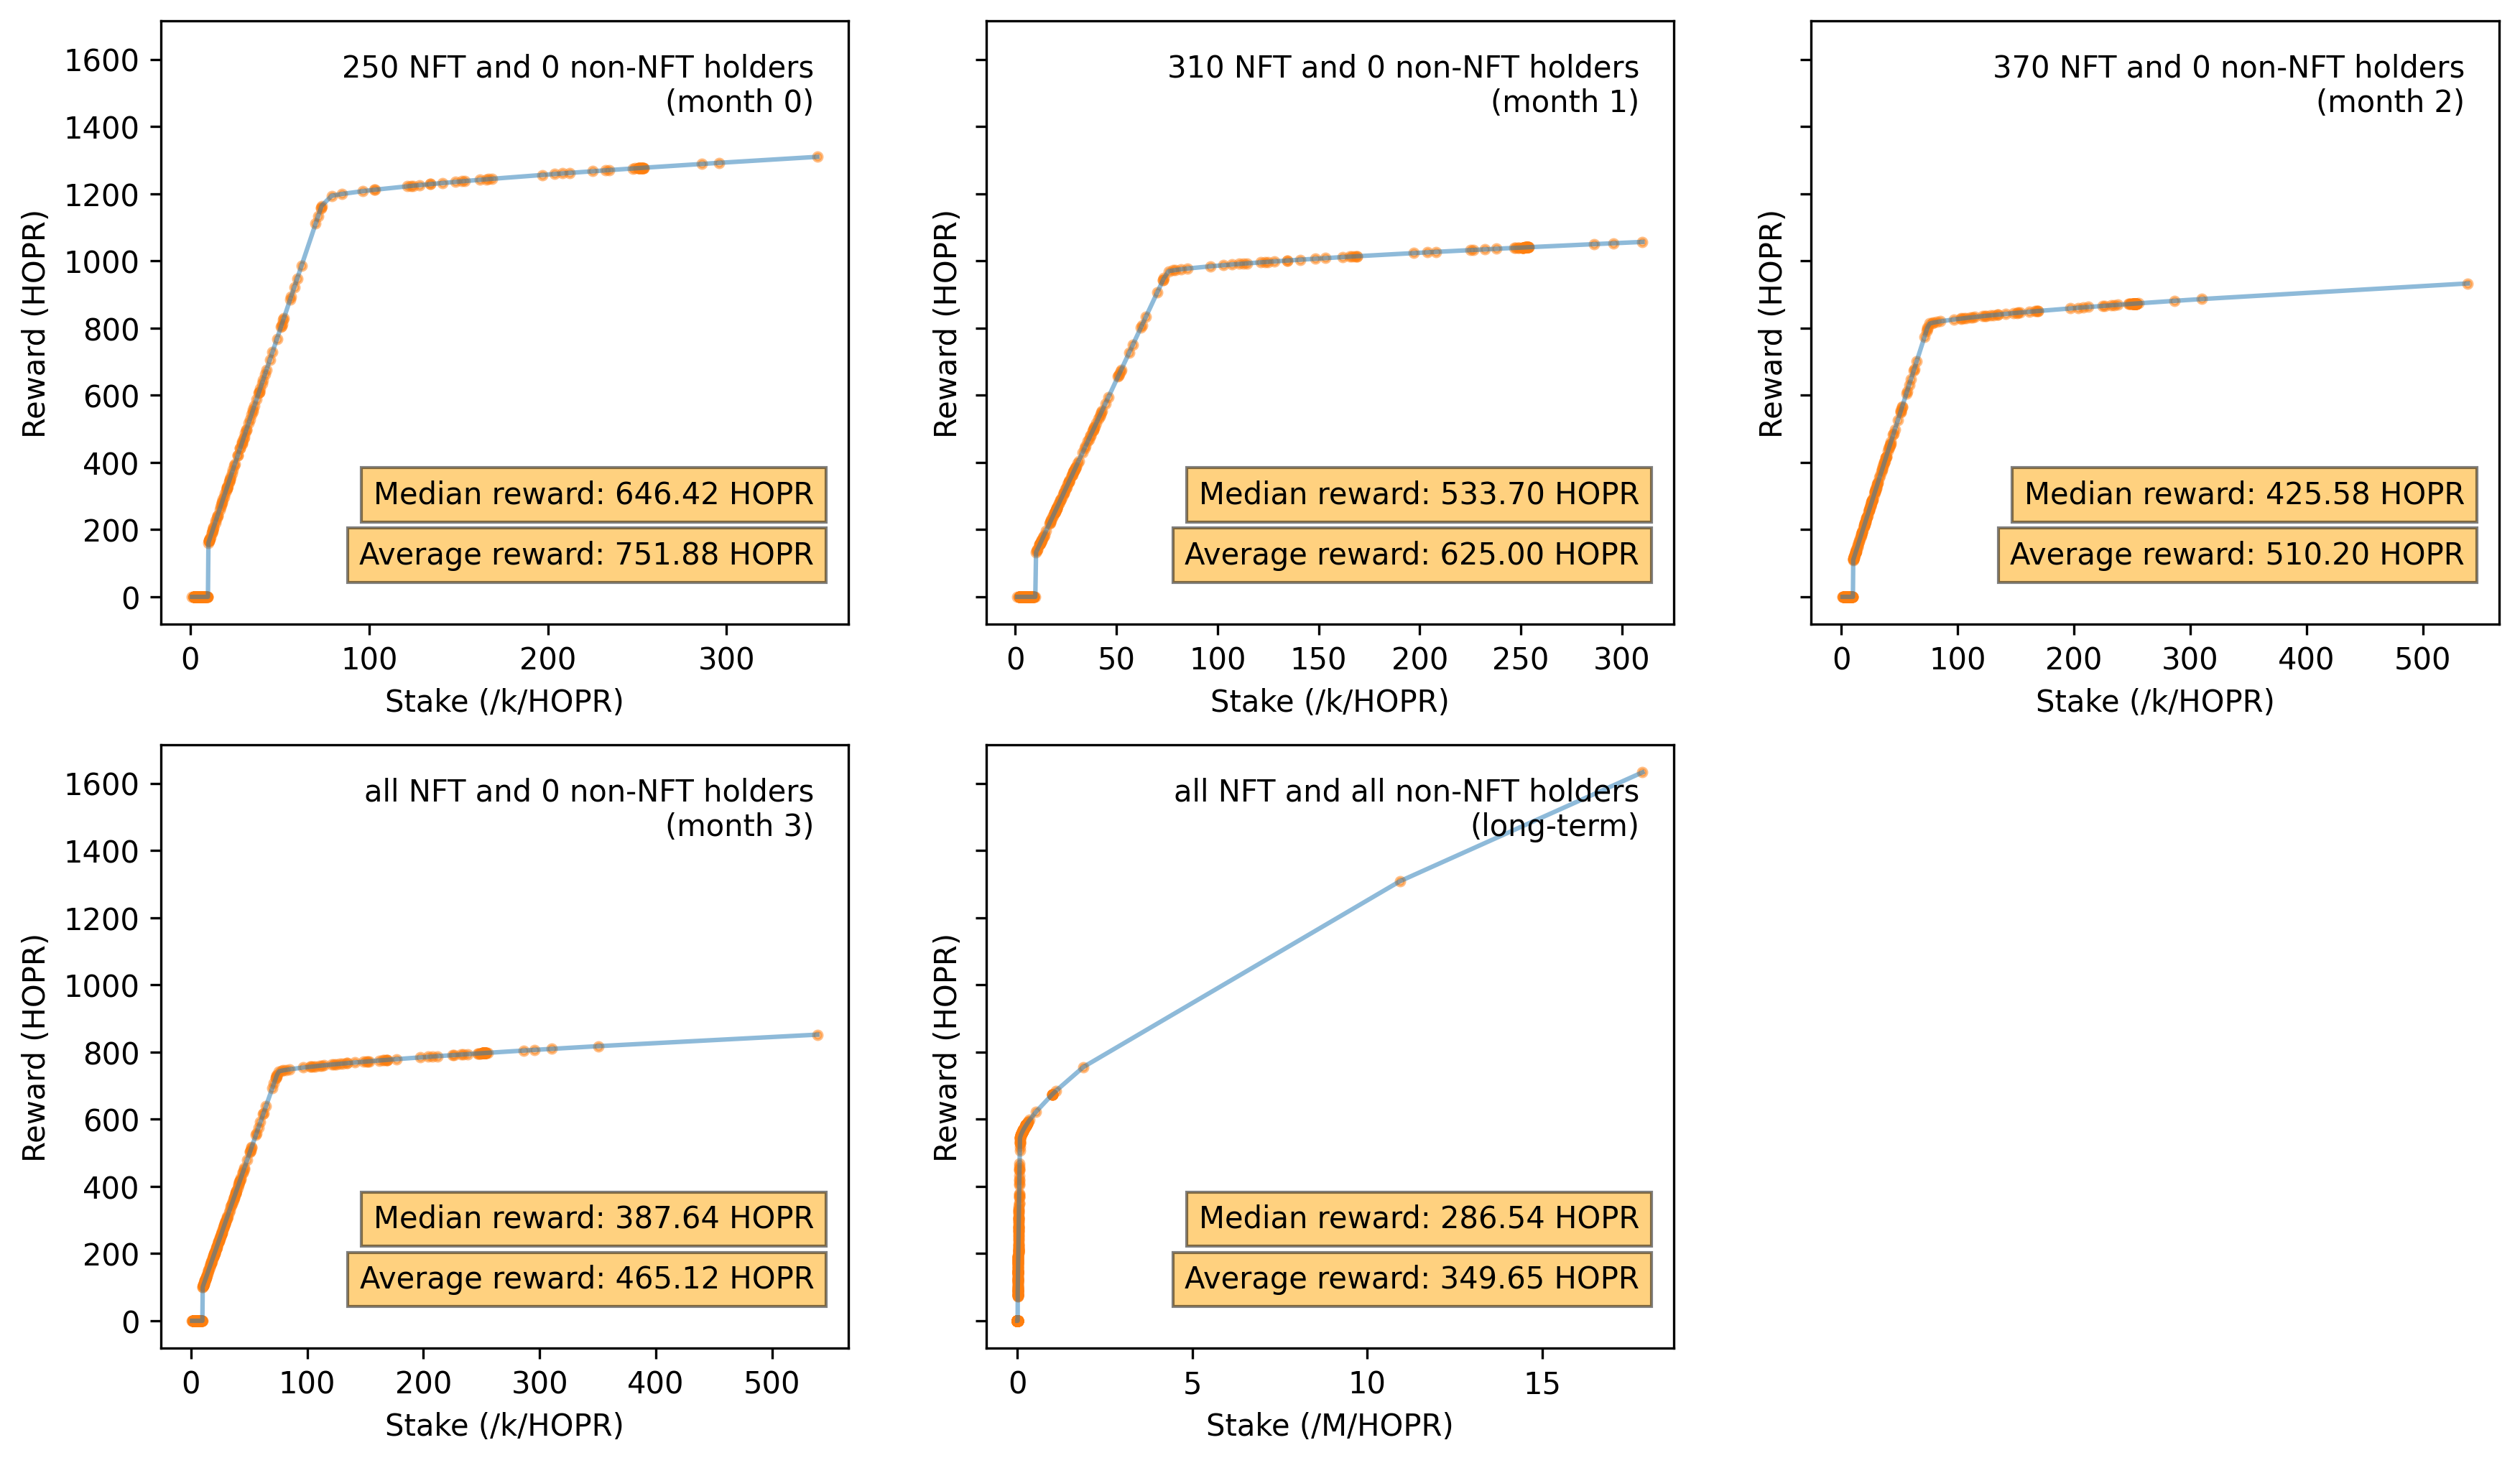

In [28]:

_, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=300, sharey=True)
axes = axes.flatten()
options = deepcopy(prefered_vars)

for opt, ax in zip(options, axes):
    stakes = []

    for data, count in zip(datas, opt["data_count"]):
        if not count:
            continue
        if count == "all":
            stakes.extend(data)
        else:
            stakes.extend(random.sample(data, count))        

    stakes = sorted(stakes)

    lin_range = np.linspace(0, max(stakes), 1000)

    apys = compute_apy(opt, stakes, percentage=True, average=False, on_stake=True)
    global_apy = probabilistic_apy(datas, [opt], steps=200)[0]["average"] * 100

    rewards = [apy*stake/100 / 12 for apy, stake in zip(apys, stakes)]
    
    average_reward = np.mean([reward for reward, stake in zip(rewards, stakes) if stake > 10e3])
    median_reward = np.median([reward for reward, stake in zip(rewards, stakes) if stake > 10e3])

    factor, prefix = factor_and_prefix(stakes[-1])

    stakes = [s/factor for s in stakes]
    
    ax.plot(stakes, rewards, alpha=0.5)
    ax.scatter(stakes, rewards, s=8, c="#ff7f0e", alpha=0.5)
    ax.text(0.95,
            0.85,
            opt["legend"],
            transform=ax.transAxes,
            horizontalalignment='right')    
    ax.text(0.95,
            0.2,
            f"Median reward: {median_reward:.2f} HOPR",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='orange', alpha=0.5),)
    ax.text(0.95,
            0.1,
            f"Average reward: {average_reward:,.2f} HOPR",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='orange', alpha=0.5),)
    

    ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
    ax.set_ylabel("Reward (HOPR)")

# remove unused subplots
for ax in axes[len(options):]:
    ax.remove()

plt.show()

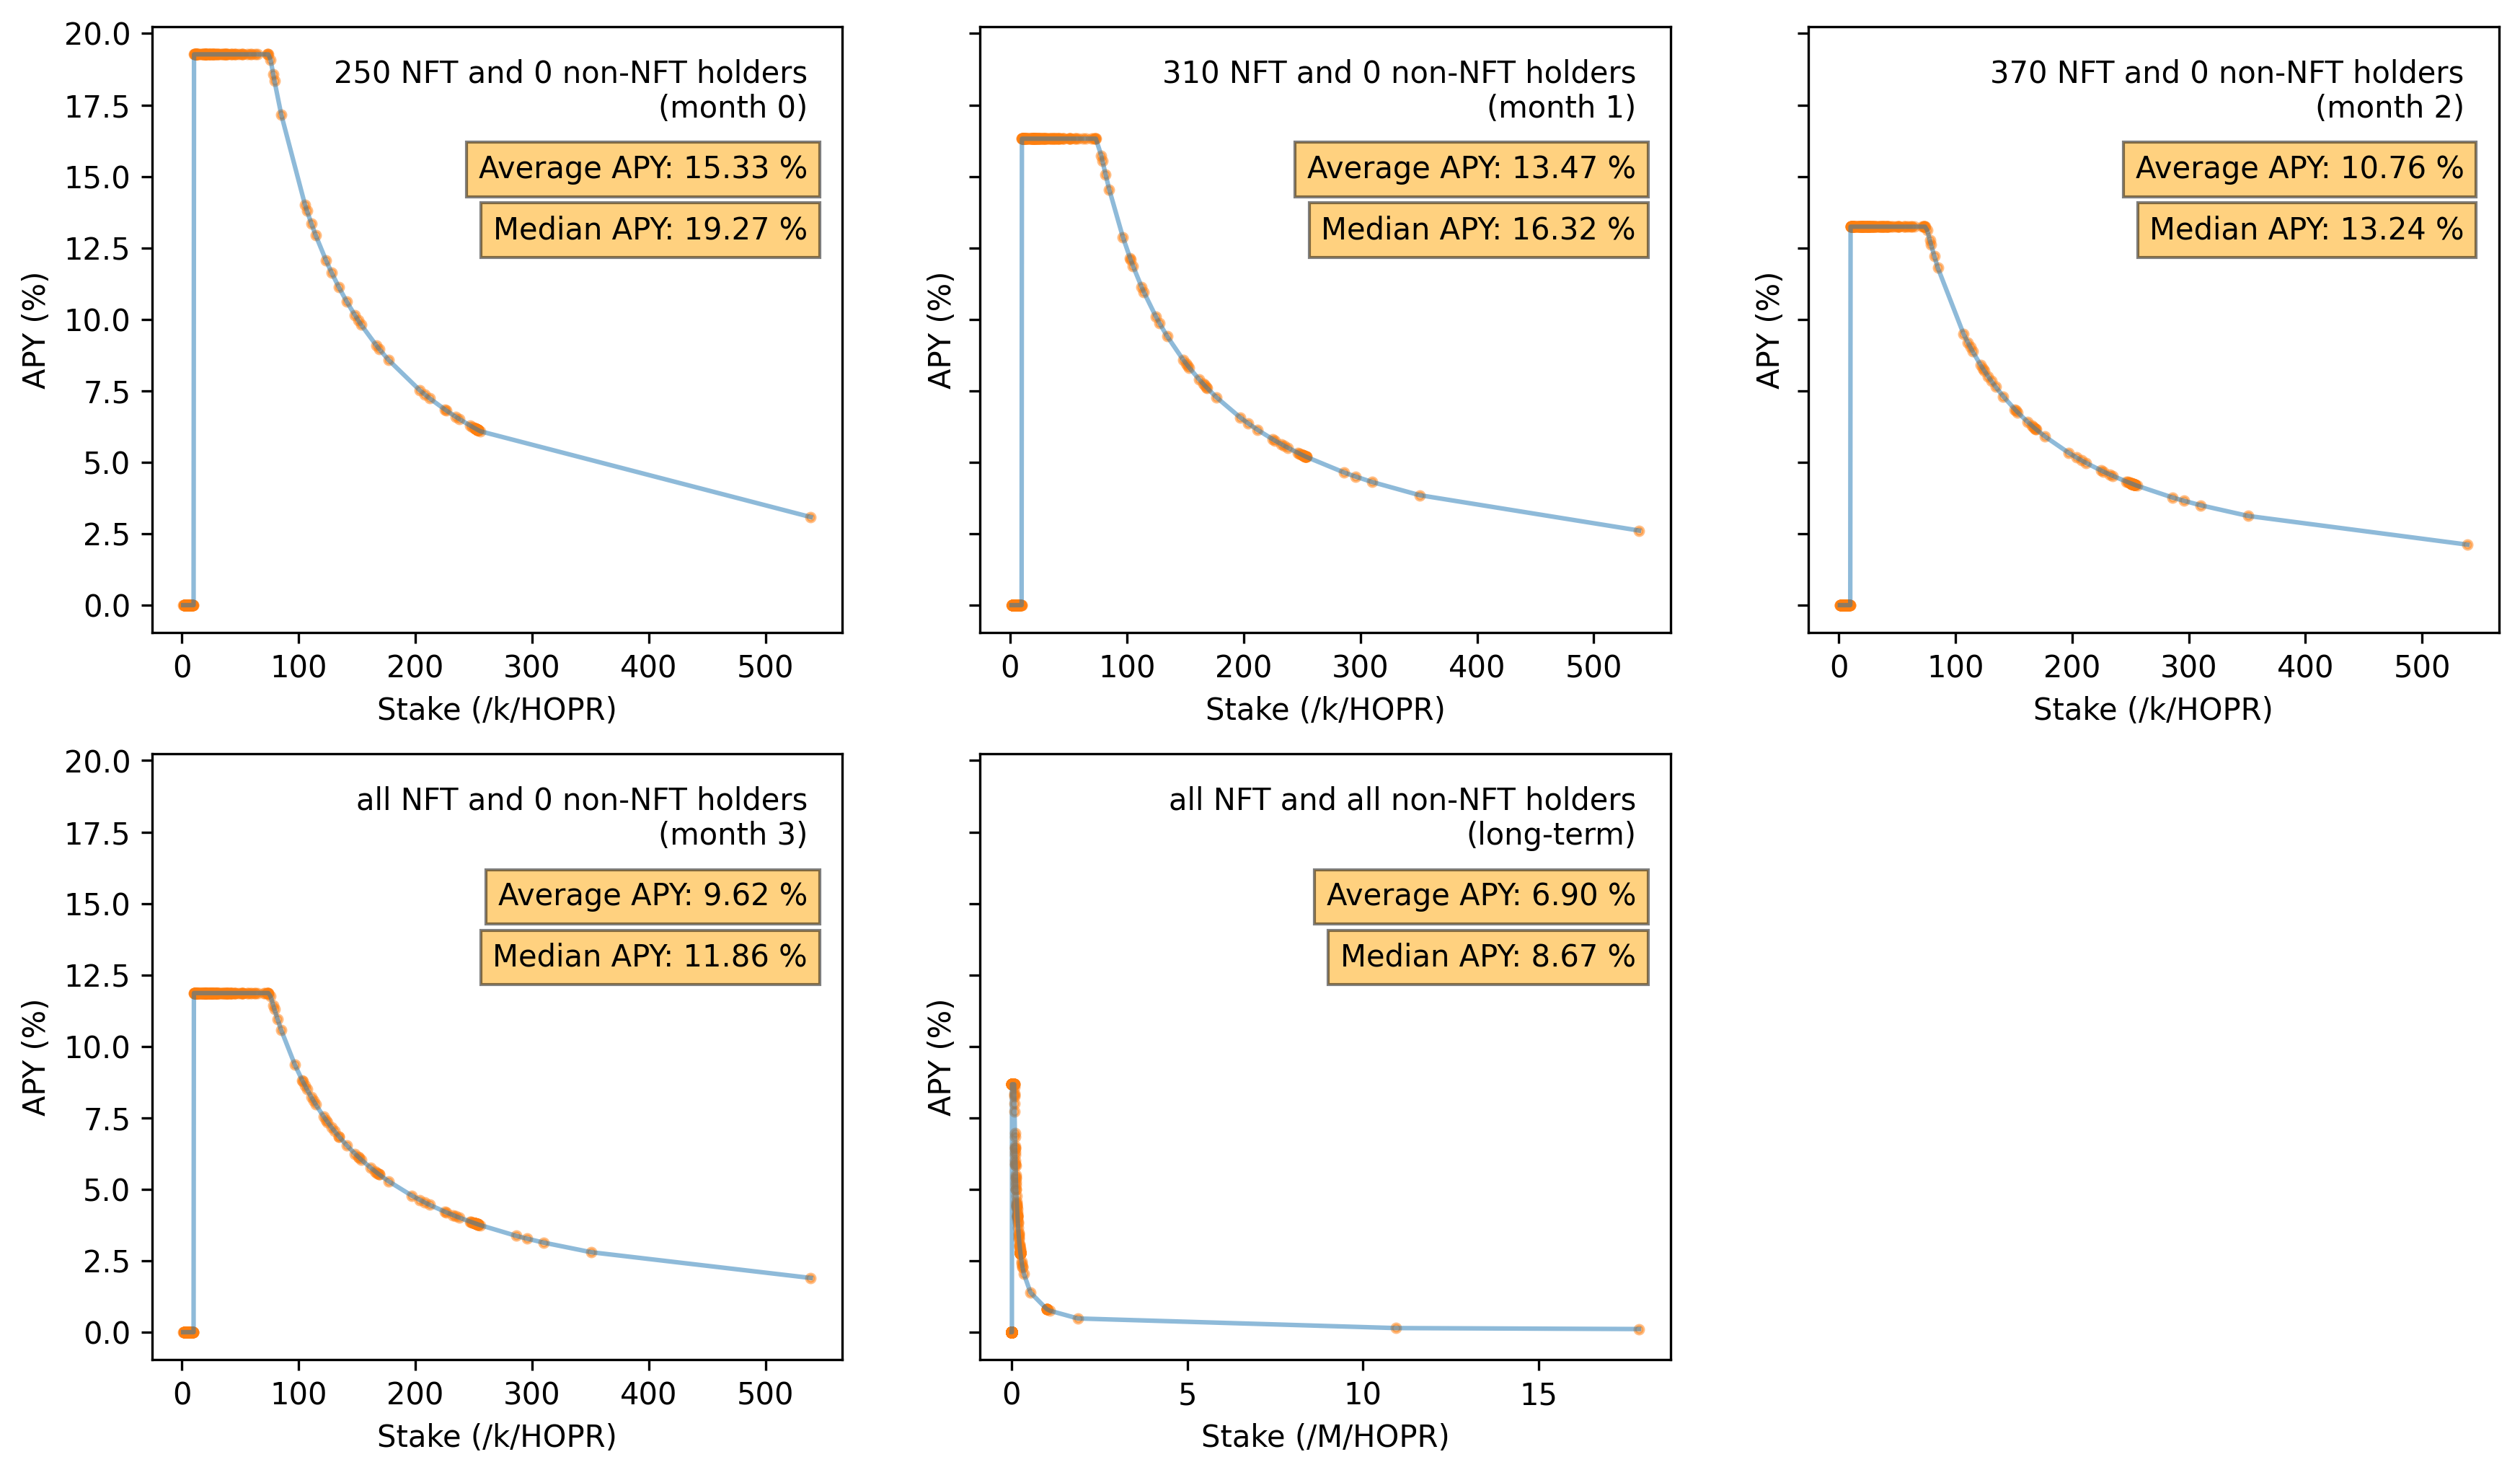

In [29]:

_, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=300, sharey=True)
axes = axes.flatten()
options = deepcopy(prefered_vars)

for opt, ax in zip(options, axes):
    stakes = []

    for data, count in zip(datas, opt["data_count"]):
        if not count:
            continue
        if count == "all":
            stakes.extend(data)
        else:
            stakes.extend(random.sample(data, count))        

    stakes = sorted(stakes)

    lin_range = np.linspace(0, max(stakes), 1000)

    apys = compute_apy(opt, stakes, percentage=True, average=False, on_stake=True)
    global_apy = probabilistic_apy(datas, [opt], steps=200)[0]["average"] * 100
    
    average_apy = np.mean([apy for apy, stake in zip(apys, stakes) if stake > 10e3])
    median_apy = np.median([apy for apy, stake in zip(apys, stakes) if stake > 10e3])

    factor, prefix = factor_and_prefix(stakes[-1])

    stakes = [s/factor for s in stakes]
    
    ax.plot(stakes, apys, alpha=0.5)
    ax.scatter(stakes, apys, s=8, c="#ff7f0e", alpha=0.5)
    ax.text(0.95,
            0.85,
            opt["legend"],
            transform=ax.transAxes,
            horizontalalignment='right')    
    ax.text(0.95,
            0.75,
            f"Average APY: {average_apy:,.2f} %",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='orange', alpha=0.5),)
    ax.text(0.95,
        0.65,
        f"Median APY: {median_apy:,.2f} %",
        transform=ax.transAxes,
        horizontalalignment='right',
        bbox=dict(facecolor='orange', alpha=0.5),)

    ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
    ax.set_ylabel("APY (%)")

# remove unused subplots
for ax in axes[len(options):]:
    ax.remove()

plt.show()

In [30]:
investor_node_count = [1, 25, 50, 100, 133, 400]
hopr_value = 0.05
investor_budget = 0.5e6 / hopr_value

def split_to_buckets(value, bucket_count, min_amount, max_amount):
    average = value / bucket_count

    if max_amount >= average and average >= min_amount:
        return [average] * bucket_count
    
    if average < min_amount:
        return split_to_buckets(value, bucket_count-1, min_amount, max_amount) + [0]
    
    filled_buckets = min(int(value / max_amount), bucket_count -1)
    remaining_value = value - filled_buckets * max_amount
    remaining_buckets = bucket_count - filled_buckets

    return [max_amount] * filled_buckets + split_to_buckets(remaining_value, remaining_buckets, min_amount, max_amount*2)

for node_count in investor_node_count:
    datas = [staking_info_nft_holders, staking_info_non_nft_holders, [investor_budget / node_count]*node_count]

    options = [deepcopy(prefered) for _ in range(2)]

    options[0]["data_count"] = ["all", 0, "all"]
    options[1]["data_count"] = ["all", "all", "all"]

    apys = probabilistic_apy(datas, options, 200)

    print(f"Investor with {int(investor_budget):,}HOPR and {node_count} nodes in the network")
    for idx, (opt, apy) in enumerate(zip(options, apys)):
        opt["legend"] = f"{opt['data_count'][0]} NFT and {opt['data_count'][1]} non-NFT holders {opt['data_count'][2]} investors nodes "

        if opt["data_count"][2] == "all":
            tf_stakes = stake_transformation(datas[2], **opt["model_arguments"])
        else:
            tf_stakes = [0]

        reward = [tf_stake * apy["average"] for tf_stake in tf_stakes] 

        print(f"    {opt['legend']}: {sum(reward):,.2f}HOPR -> {sum(reward)/investor_budget:.2%} APY (network APY: {apy['average']:.2%})")


    # generate_simulation_graph(datas, options, title=f"Realistic scenario: 250 node runners day 1 + 15/week\nbudget of {prefered_vars[0]['budget']/1000:.0f}k every {prefered_vars[0]['period_in_months']} month, ticket price at 0.001", cols=2)

Investor with 10,000,000HOPR and 1 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 21,136.40HOPR -> 0.21% APY (network APY: 12.12%)
    all NFT and all non-NFT holders all investors nodes : 15,893.25HOPR -> 0.16% APY (network APY: 9.11%)
Investor with 10,000,000HOPR and 25 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 214,168.54HOPR -> 2.14% APY (network APY: 10.24%)
    all NFT and all non-NFT holders all investors nodes : 167,467.21HOPR -> 1.67% APY (network APY: 8.01%)
Investor with 10,000,000HOPR and 50 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 350,266.29HOPR -> 3.50% APY (network APY: 8.83%)
    all NFT and all non-NFT holders all investors nodes : 282,396.54HOPR -> 2.82% APY (network APY: 7.12%)
Investor with 10,000,000HOPR and 100 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 528,497.52HOPR -> 5.28% APY (network APY: 6.92%)
    all NFT and all non-NFT hol

In [31]:
# datas = [staking_info_nft_holders, staking_info_non_nft_holders, [investor_budget / node_count]*node_count]

ct_candidates = [stake for stake in staking_info_all if stake > 10e3]
median_staker = ct_candidates[len(ct_candidates)//2]

median_stakes = [median_staker]

datas = [staking_info_nft_holders, staking_info_non_nft_holders, 0]

options = [deepcopy(prefered) for _ in range(2)]

options[0]["data_count"] = ["all", 0, 0]
options[1]["data_count"] = ["all", "all", 0]

apys = probabilistic_apy(datas, options, 200)

print(f"{median_staker:,}HOPR staker with {1} nodes in the network")
for idx, (opt, apy) in enumerate(zip(options, apys)):
    tf_stakes = stake_transformation(median_stakes, **opt["model_arguments"])

    reward = [tf_stake * apy["average"] for tf_stake in tf_stakes] 
    
    print(f"    : {sum(reward):,.2f}HOPR -> {sum(reward)/sum(median_stakes):.2%} APY (network APY: {apy['average']:.2%})")

39,206.7841314488HOPR staker with 1 nodes in the network
    : 4,787.98HOPR -> 12.21% APY (network APY: 12.21%)
    : 3,593.12HOPR -> 9.16% APY (network APY: 9.16%)


In [32]:
apy["average"] 

0.09164534319367121

In [33]:
len(staking_info_all)

861

In [34]:
10e3

10000.0